In [6]:
import operator        
import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
# import pandas_profiling as pdf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, lars_path, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# pointer to scaler I want to use to easily swap scalers
use_transform = RobustScaler

import scipy
import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#!conda install -y -conda-forge  xgboost 
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

#!conda install -y -c conda-forge lightgbm
import lightgbm
from lightgbm import LGBMRegressor


#!conda install -y -c districtdatalabs yellowbrick
# import yellowbrick
# from yellowbrick.features import JointPlotVisualizer, ParallelCoordinates
# from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

#!conda install -y -c conda-forge mlxtend
# import mlxtend
# from mlxtend.regressor import StackingCVRegressor

import ipywidgets as widgets
from IPython.display import clear_output
pd.options.display.max_columns=None
#pd.options.display.max_rows=None

RANDOM_STATE=42
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

print(datetime.datetime.now())

print ("%-20s %s"% ("numpy", np.__version__))
print ("%-20s %s"% ("pandas", pd.__version__))
print ("%-20s %s"% ("seaborn", sns.__version__))
print ("%-20s %s"% ("matplotlib", matplotlib.__version__))
print ("%-20s %s"% ("sklearn", sklearn.__version__))
print ("%-20s %s"% ("scipy", scipy.__version__))
print ("%-20s %s"% ("xgboost", xgboost.__version__))
print ("%-20s %s"% ("lightgbm", lightgbm.__version__))
#print ("%-20s %s"% ("yellowbrick", yellowbrick.__version__))
#print ("%-20s %s"% ("mlxtend", mlxtend.__version__))


2020-10-12 18:37:47.894039
numpy                1.18.1
pandas               1.0.1
seaborn              0.10.0
matplotlib           3.2.1
sklearn              0.22.1
scipy                1.4.1
xgboost              1.2.0
lightgbm             3.0.0


### 1. Import

In [ ]:
# import train data
datadir = "https://raw.githubusercontent.com/druce/iowa/master/data/"
datafile = datadir + "train.csv"
df_raw = pd.read_csv(datafile)
print(df_raw.shape)
display(df_raw.head())


#### Initial exploration

In [ ]:
response = 'SalePrice'
sns.distplot(df_raw[response], kde=False, fit=stats.lognorm);


In [ ]:
sns.distplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), kde=False, fit=stats.norm);


In [ ]:
res = stats.probplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), plot=plt);

In [ ]:
widget_cats = []
widget_nums = []

for col in df_raw.columns:
    if col == response:
        continue
    if df_raw[col].dtype == np.dtype('O'):
        widget_cats.append(col)
    elif len(df_raw[col].value_counts()) <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)


In [ ]:
# interactive widget for continuous variables
df = df_raw
def on_value_change1(change):
    do_refresh(change['new'], gColor)

def on_value_change2(change):
    do_refresh(gVar, change['new'])

def do_refresh(var=widget_nums[0], colorby="Neighborhood"):

    global gVar
    gVar = var
    global gColor
    gColor = colorby
    
    clear_output()
    dropdown1 = widgets.Dropdown(
        options=widget_nums,
        value=var,
        description='Variable:',
        disabled=False,)
    display(dropdown1)

    dropdown1.observe(on_value_change1, names='value')

    dropdown2 = widgets.Dropdown(
        options=widget_cats,
        value=colorby,
        description='Color by:',
        disabled=False,)
    display(dropdown2)
    dropdown2.observe(on_value_change2, names='value')
    
    z = df.loc[~df[response].isna()]

    norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
    
    colordict = {k: i for i, k in enumerate(z[colorby].unique())}
    
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  #hue=colorby,
                  #palette=colordict
                 )

do_refresh()


In [ ]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
    

In [ ]:
# import test data
datafile = datadir + "test.csv"
df_test = pd.read_csv(datafile)
df_test[response]=np.nan
df_test.head()


In [ ]:
# concatenate train and test for feature engineering across both
df_raw=pd.concat((df_raw, df_test)).set_index('Id')
print(df_raw.shape)


### 2. Scrub

In [ ]:
df_raw.columns

Per docs
23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables 

Nominal (categorical)
- MS SubClass
- MS Zoning
- Street
- Alley
- Land Contour
- Lot Config
- Neighborhood
- Condition 1
- Condition 2
- Bldg Type
- House Style
- Roof Style 
- Roof Matl
- Exterior 1
- Exterior 2
- Mas Vnr Type
- Foundation
- Heating
- Central Air
- Garage Type
- Misc Feature
- Sale Type
- Sale Condition

Ordinal (categorical but map to numerical, like Po/Fa/TA/Gd/Ex)
- Lot Shape
- Utilities
- Land Slope
- Overall Qual
- Overall Cond
- Exter Qual
- Exter Cond
- Bsmt Qual
- Bsmt Cond
- Bsmt Exposure
- BsmtFin Type 1
- BsmtFinType 2
- HeatingQC
- Electrical
- KitchenQual
- Functional
- FireplaceQu
- Garage Finish 
- Garage Qual
- Garage Cond
- Paved Drive
- Pool QC
- Fence

Discrete (int)
- Year Built
- Year Remod/Add
- Bsmt Full Bath
- Bsmt Half Bath
- Full Bath
- Half Bath
- Bedroom
- Kitchen
- TotRmsAbvGrd
- Fireplaces
- Garage Yr Blt 
- Garage Cars
- Mo Sold
- Yr Sold

Continuous (float)
- Lot Frontage
- Lot Area
- Mas Vnr Area
- BsmtFin SF 1
- BsmtFin SF 2
- Bsmt Unf SF
- Total Bsmt SF
- 1st Flr SF
- 2nd Flr SF
- Low Qual Fin SF
- Gr Liv Area
- Garage Area
- Wood Deck SF
- Open Porch SF
- Enclosed Porch
- 3-Ssn Porch
- Screen Porch
- Pool Area
- Misc Val

Response
- SalePrice


In [ ]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
               'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
               'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 
               'SaleType', 'SaleCondition']

ordinal = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
           'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 
           'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PavedDrive', 'PoolQC', 'Fence',]

numerical = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
             'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
             'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 
             
             'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',  'BsmtFinSF2', 
             'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
             '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

response='SalePrice'

print(df_raw.shape)
print(len(categorical))
print(len(ordinal))
print(len(numerical))
df_raw = df_raw[categorical + ordinal + numerical]
print(df_raw.shape)


In [ ]:
df_raw.head()


In [ ]:
# remove sf > 4000 per docs, http://jse.amstat.org/v19n3/decock.pdf
df= df_raw.loc[~((df_raw['GrLivArea'] > 4000) & (~df_raw[response].isna()))]


#### Map categorical to int

In [ ]:
# map all the columns listed as ordinal to int
# per http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

# map these 9 quality label cols to int

qdict = {
    'Po' : 0,
    'Fa' : 1,
    'TA' : 2,
    'Gd' : 3,
    'Ex' : 4,
    np.nan : 2
}

qcols = ['ExterQual',
         'ExterCond',
         'BsmtQual',
         'BsmtCond',
         'HeatingQC',
         'KitchenQual',
         'GarageQual',
         'GarageCond',
         'FireplaceQu'         
        ]

# these values are very rare (<=5), roll poor->fair, excellent->good
df.loc[df['ExterCond']=='Po', 'ExterCond'] = 'Fa'
df.loc[df['BsmtCond']=='Po', 'BsmtCond'] = 'Fa'
df.loc[df['HeatingQC']=='Po', 'HeatingQC'] = 'Fa'
df.loc[df['GarageQual']=='Po', 'GarageQual'] = 'Fa'
df.loc[df['GarageQual']=='Ex', 'GarageQual'] = 'Gd'
df.loc[df['GarageCond']=='Ex', 'GarageCond'] = 'Gd'

for col in qcols:
    print(col)
    print(df[col].value_counts())
    df.loc[:, col] = df[col].apply(lambda q: qdict[q])
    df.loc[:, col] = df[col].astype(int)
    print(df[col].value_counts())
    

In [ ]:
print(df['LandSlope'].value_counts())

slope_dict = {
    'Gtl': 0,
    'Mod' : 1,
    'Sev' : 2,
}

df['LandSlope'] = df['LandSlope'].apply(lambda q: slope_dict[q])

print(df['LandSlope'].value_counts())


In [ ]:
print(df['GarageFinish'].value_counts())

garagefinish_dict = {
    np.nan : 0,
    'Unf': 1,
    'RFn' : 2,
    'Fin' : 3,
}
df['GarageFinish'] = df['GarageFinish'].apply(lambda q: garagefinish_dict[q])

print(df['GarageFinish'].value_counts())


In [ ]:
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement

print(df['BsmtExposure'].value_counts())

BsmtExposure_dict = {
    np.nan : 0,
    'No' : 1,
    'Mn' : 2, 
    'Av' : 3, 
    'Gd' : 4
}
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda q: BsmtExposure_dict[q])

print(df['BsmtExposure'].value_counts())


In [ ]:
#        Typ	Typical Functionality
#        Min1	Minor Deductions 1
#        Min2	Minor Deductions 2
#        Mod	Moderate Deductions
#        Maj1	Major Deductions 1
#        Maj2	Major Deductions 2
#        Sev	Severely Damaged
#        Sal	Salvage only

print(df['Functional'].value_counts())

functional_dict = {
    np.nan:  4,
    'Sev':   0,
    'Maj1':  0,
    'Maj2':  0,
    'Mod':   1,
    'Min2':  2,
    'Min1':  3,
    'Typ' :  4,
}
df['Functional'] = df['Functional'].apply(lambda q: functional_dict[q])

print(df['Functional'].value_counts())


In [ ]:
#        NA	No Basement
#        Unf	Unfinshed
#        LwQ	Low Quality
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        ALQ	Average Living Quarters
#       GLQ	Good Living Quarters

print(df['BsmtFinType1'].value_counts())

bsmt_fintype_dict = {
    np.nan : 0,
    'NA' : 0,
    'Unf' : 1,
    'LwQ' : 2,
    'BLQ' : 3,
    'Rec' : 4,
    'ALQ' : 5,
    'GLQ' : 6
}

df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda q: bsmt_fintype_dict[q])

print(df['BsmtFinType1'].value_counts())

print(df['BsmtFinType2'].value_counts())
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda q: bsmt_fintype_dict[q])
print(df['BsmtFinType2'].value_counts())


In [ ]:
#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
print(df['LotShape'].value_counts())
 
lotshape_dict = {
    np.nan : 0,
    'Reg' : 0,
    'IR1' : 1,
    'IR2' : 2,
    'IR3' : 2,
}    

df['LotShape'] = df['LotShape'].apply(lambda q: lotshape_dict[q])

print(df['LotShape'].value_counts())


In [ ]:
#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed

print(df['Electrical'].value_counts())
 
elec_dict = {
    np.nan : 0,
    'Mix' : 0,
    'FuseP' : 0,
    'FuseF' : 2,
    'FuseA' : 3,
    'SBrkr' : 4,
}    

df['Electrical'] = df['Electrical'].apply(lambda q: elec_dict[q])

print(df['Electrical'].value_counts())


In [ ]:
# Paved Drive (Ordinal): Paved driveway

#        Y	Paved 
#        P	Partial Pavement
#        N	Dirt/Gravel
        
print(df['PavedDrive'].value_counts())
 
pave_dict = {
    'N' : 0,
    'P' : 1,
    'Y' : 2,
}    

df['PavedDrive'] = df['PavedDrive'].apply(lambda q: pave_dict[q])

print(df['PavedDrive'].value_counts())


In [ ]:
# Fence (Ordinal): Fence quality
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence

print(df['Fence'].value_counts())

fence_dict = {
    np.nan : 0,
    'MnWw' : 1,
    'GdWo' : 2,
    'MnPrv' : 3,
    'GdPrv' : 4,
}

df['Fence'] = df['Fence'].apply(lambda q: fence_dict[q])

print(df['Fence'].value_counts())


In [ ]:
# Map these categorical vars 

#        1Story	One story
#        SFoyer	Split Foyer
#        SLvl	Split Level
#     1.5Fin	One and one-half story: 2nd level finished
#        1.5Unf	One and one-half story: 2nd level unfinished
#        2Story	Two story
#        2.5Fin	Two and one-half story: 2nd level finished
#        2.5Unf	Two and one-half story: 2nd level unfinished

print(df['HouseStyle'].value_counts())

story_dict = {
    '1Story' : 0,
    'SFoyer' : 1,
    'SLvl'   : 2,
    '1.5Unf' : 3,
    '1.5Fin' : 4,
    '2Story' : 5,
    '2.5Unf' : 6,
    '2.5Fin' : 7    
}

df['HouseStyle'] = df['HouseStyle'].apply(lambda q: story_dict[q])

print(df['HouseStyle'].value_counts())


In [ ]:
print(df['CentralAir'].value_counts())
df['CentralAir'] = df['CentralAir'] == 'Y' 
df['CentralAir'] = df['CentralAir'].astype(int)
print(df['CentralAir'].value_counts())


In [ ]:
df.head()

#### Impute / fill NAs

In [ ]:
# For garage, basement, bathroom/half, assume if missing then this feature is not present

zlist = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
         '2ndFlrSF','LowQualFinSF',
         'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
         'Fireplaces','GarageCars','GarageArea',
         'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
         'PoolArea','MiscVal']
        
for col in zlist:
    print(col)
    df[col].fillna(0, inplace=True)
for col in ['GarageYrBlt']:
    print(col)
    df[col].fillna(df['YearBuilt'], inplace=True)
    df[col]=df[col].astype(int)
for col in ['GarageType']:
    print(col)
    df[col].fillna('None', inplace=True)

df.loc[:, 'BsmtFullBath']=df['BsmtFullBath'].astype(int)
df.loc[:, 'BsmtHalfBath']=df['BsmtHalfBath'].astype(int)
df.loc[:, 'GarageCars']=df['GarageCars'].astype(int)


In [ ]:
for col in df.columns:
    print(col)
    print (df[col].value_counts())
    print()
    

In [ ]:
df.loc[df['MSSubClass'] == 150]

In [ ]:
display(df.groupby(['MSSubClass']).mean()[[response]].reset_index().sort_values(response))
display(df.groupby(['MSSubClass']).count()[[response]].reset_index().sort_values(response))

In [ ]:
#        020	1-STORY 1946 & NEWER ALL STYLES
#        030	1-STORY 1945 & OLDER
#        040	1-STORY W/FINISHED ATTIC ALL AGES
#        045	1-1/2 STORY - UNFINISHED ALL AGES
#        050	1-1/2 STORY FINISHED ALL AGES
#        060	2-STORY 1946 & NEWER
#        070	2-STORY 1945 & OLDER
#        075	2-1/2 STORY ALL AGES
#        080	SPLIT OR MULTI-LEVEL
#        085	SPLIT FOYER
#        090	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES

print(df['MSSubClass'].value_counts())

MSSubClass_dict = {
    40 : 70,
    45 : 45,
    150 : 160,
    180 : 30,
    20 : 20,
    60 : 60,
    50 : 50,
    120 : 120,
    30 : 30,
    160 : 160,
    70 : 70,
    80 : 80,
    90 : 90,
    190 : 190,
    85 : 85,
    75 : 75,
}

df['MSSubClass'] = df['MSSubClass'].apply(lambda q: MSSubClass_dict[q])

print(df['MSSubClass'].value_counts())


In [ ]:
# fill missing MSZoning using most popular value by subclass
df.loc[:, 'MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing LotFrontage using median value by Neighborhood
# could also impute using LotArea
df.loc[:, 'LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [ ]:
# impute categorical strings

oimpute = {'MSZoning' : 'RL',
           'MasVnrType' : 'None',
           'Utilities': 'AllPub',
           'Exterior1st': 'VinylSd',
           'Exterior2nd': 'VinylSd',
           'BsmtExposure' : 'No',
           'BsmtFinType1': 'Unf',
           'BsmtFinType2': 'Unf',
           'Electrical' : 'SBrkr',
           'GarageType'  : 'Attchd',
           'GarageFinish' : 'Unf',
           'GarageCond' : 'TA',
           'Functional' : 'Typ',
           'SaleType': 'WD',
           'Alley': 'None',
           'FireplaceQu': 'TA',
           'PoolQC' : 'None',
           'Fence': 'Other',
           'MiscFeature': 'Other',
          }

def impute_strings(features, ocols, groupby):
    
    for col in ocols:
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col, 'missing', features[col].isna().sum())
            print(features[col].value_counts())
            if groupby:
                features[col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mode()[0]))
            features[col].fillna(oimpute[col], inplace=True)
    return features

ocols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t == np.dtype('O')])

df = impute_strings(df, ocols, None)


In [ ]:
# impute mean for missing floats - mean by neighborhood

def impute_floats(features, fcols, groupby='Neighborhood', response=response):

    for col in fcols:
        if col == response:
            continue
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col)
            print('missing', features[col].isna().sum())
            display(df.loc[df[col].isna()])
            if groupby:
                features.loc[:,col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mean()))
            else:
                features.loc[:,col] = features[col].mean()
                
    return features

# set this to 0 since MasVnrType is always 'None' when MasVnrArea is nan
df.loc[df['MasVnrArea'].isna(), 'MasVnrArea'] = 0

# set this to 0 since these do not seem to have a basement
df.loc[df['BsmtFinSF1'].isna(), 'BsmtFinSF1'] = 0
df.loc[df['BsmtFinSF2'].isna(), 'BsmtFinSF2'] = 0
df.loc[df['BsmtUnfSF'].isna(), 'BsmtUnfSF'] = 0
df.loc[df['TotalBsmtSF'].isna(), 'TotalBsmtSF'] = 0

fcols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t in numeric_dtypes])

df = impute_floats(df, fcols, 'Neighborhood')


In [ ]:
# map all remaining categorical variables to ints by grouping and sorting by mean SalePrice
# i.e. categorical var with lowest average saleprice maps to 0, next lowest is 1, etc.
# numeric values potentially allow interaction features

labelencoded = []

def myLabelEncoder(df, column, target, order_only=True, verbose=True):
    
    temp_df= df.loc[~df[target].isna()][[column, target]] \
        .groupby(column) \
        .agg(np.mean) \
        .sort_values(target) \
        .reset_index()
    
    if order_only == True:
        mapdict = dict(zip(temp_df[column], temp_df.index))
    else:
        mapdict = dict(zip(temp_df[column], temp_df[target]))

    mapdict[np.nan] = np.nan

    if verbose:
        print(mapdict)
    
    return df[column].apply(lambda q: mapdict[q])

for col in df.columns:
    if df[col].dtype in numeric_dtypes:
        continue
    else:
        df[col] = myLabelEncoder(df, col, response)
        labelencoded.append(col)

#### Roll up rare categorical values

In [ ]:
print(df['OverallQual'].value_counts())
df.loc[df['OverallQual'] == 1, 'OverallQual'] = 2
print(df['OverallQual'].value_counts())

print(df['OverallCond'].value_counts())
df.loc[df['OverallCond'] == 1, 'OverallCond'] = 2
print(df['OverallCond'].value_counts())


In [ ]:
# roll up low cardinality categorical variables

def rollup_low_cardinality(features, threshold):
    """Rollup least frequent categorical features, up to total threshold observations rolled up"""
    for col in features.columns:
        # skip numerics
        if (features[col].dtype in numeric_dtypes):
            continue
        
        print(col)
        counts = features[col].value_counts()
        howmany=0
        vals = []
        for i, (val, c) in reversed(list(enumerate(zip(list(counts.index), list(counts))))):
            if howmany + c < threshold:
                print(val, c)
                howmany += c
                vals += [val]
            else:
                break
        if len(vals) > 1:
            print ('Rollup', vals)
            for v in vals:
                features.loc[features[col] == v, col] = 'Rollup'
        print()
    return features

def rollup_low_cardinality_int(df, preds, threshold):
    """Rollup least frequent ordered features
    if < threshold, roll into next higher
    if highest, roll into next lower
    """
    for col in preds:
        print(col)
        counts = df[col].value_counts()
        counts = df[col].value_counts().sort_index()
        print(counts)
        indexlist = list(counts.index)
        for i, val in enumerate(indexlist):
            if counts[val] < threshold:
                if val < len(indexlist)-1:
                    # not last
                    print(val, '=>', indexlist[i+1])
                    df.loc[df[col]==val, col] = indexlist[i+1]
                    # update counts so you don't roll up if now > thresh
                    counts[indexlist[i+1]] += counts[indexlist[i]]
                else:
                    print(val, '=>', indexlist[i-1])
                    df.loc[df[col]==val, col] = indexlist[i-1]
                    #no need to update since last

    return df

df = rollup_low_cardinality(df, 25)

intcats = ['LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
           'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
           'Heating','GarageType','SaleType','SaleCondition','LotShape','LandSlope',
           'ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','Electrical',
           'KitchenQual','GarageFinish','GarageQual','GarageCond','PavedDrive',
           'BsmtFullBath','HalfBath','KitchenAbvGr','Fireplaces',]

df = rollup_low_cardinality_int(df, intcats, 5)


#### Engineer

In [ ]:
# Compute additional features

#df['MS SubClass']=df['MS SubClass'].astype(str)
df['TotalFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['PorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

df['BsmtFullBath'].fillna(0, inplace=True)
df.loc[df['BsmtFullBath'] > 2, 'BsmtFullBath'] = 2
df['BsmtHalfBath'].fillna(0, inplace=True)
df['TotalBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
df.loc[df['TotalBath'] >=4, 'TotalBath'] = 4
df['BsmtBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df.loc[df['BsmtBath'] >= 1, 'BsmtBath'] = 1

df['BsmtFullBath'] = df['BsmtFullBath'].astype(int)
df.drop(columns=['BsmtHalfBath'], inplace=True)

df['AvgBltRemod'] = (df['YearBuilt'] + df['YearRemodAdd']) / 2
df['AvgBltRemod'] = 2010 - df['AvgBltRemod'] 
df['YearBuilt'] = 2010 - df['YearBuilt'] 
df['PreWarYearBuilt'] = df['YearBuilt'].apply(lambda x: 68-x if x < 68 else 0) 
df['RecentYearBuilt'] = df['YearBuilt'].apply(lambda x: 12-x if x < 12 else 0) 
df['YearRemodAdd'] = 2010 - df['YearRemodAdd'] 
df['GarageYrBlt'] = 2010 - df['GarageYrBlt'] 

# cap and floor outliers
df.loc[df['KitchenAbvGr'] > 2, 'KitchenAbvGr'] = 2
df.loc[df['GarageCars'] >= 3, 'GarageCars'] = 3
df.loc[df['TotRmsAbvGrd'] <=3, 'TotRmsAbvGrd'] = 3
df.loc[df['BedroomAbvGr'] > 6, 'BedroomAbvGr'] = 6
df.loc[df['TotRmsAbvGrd'] > 12, 'TotRmsAbvGrd'] = 12
df.loc[df['Fireplaces'] >= 3, 'Fireplaces'] = 3

# fix 1 bad value
df.loc[df['GarageYrBlt'] < 0, 'GarageYrBlt'] = 0

# Booleans
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
#df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Ratios
df['LivAreaRatio'] = df['TotalSF'] / df['LotArea']
df['BedRatio'] = df['GrLivArea'] / df['BedroomAbvGr']
df.loc[df['BedRatio'] > 2500, 'BedRatio'] = 2500
df['GarageRatio']  = df['GarageCars'] / df['BedroomAbvGr']
df.loc[df['GarageRatio'] > 5, 'GarageRatio'] = 5
df['BathRatio'] = df['TotalBath'] /  df['BedroomAbvGr']
df.loc[df['BathRatio'] > 5, 'BathRatio'] = 5
df['LotRatio'] = df['LotArea'] / df['LotFrontage']
df.loc[df['LotRatio'] > 500, 'LotRatio'] = 500
df['FireBathRatio'] = df['Fireplaces'] / df['TotalBath']
df.loc[df['FireBathRatio'] > 1.5, 'FireBathRatio'] = 1.5
# merge unpaved, partial paved
df.loc[df['PavedDrive']==1,'PavedDrive'] = 0

# df['OverallQualRatio'] = (df['OverallQual'] + 1) / (df['OverallCond'] + 1)
# df['ExterQualRatio'] = (df['ExterQual'] + 1) / (df['ExterCond'] + 1)
# df['BsmtQualRatio'] = (df['BsmtQual'] + 1) / (df['BsmtCond']   + 1)
# df['GarageQualRatio'] = (df['GarageQual'] + 1) / (df['GarageCond']   + 1)

# df['Gr Liv Area x Overall Qual'] = df['Gr Liv Area'] * df['Overall Qual']

# interaction features, have residual correlation and also look reasonable
df['TotalSF x OverallQual x OverallCond'] = df['TotalSF'] * df['OverallQual'] * df['OverallCond']
df['TotalSF x OverallQual x Functional'] = df['TotalSF'] * df['OverallQual'] * df['Functional']
df['AvgBltRemod x Functional x TotalFinSF'] = df['AvgBltRemod'] * df['Functional'] * df['TotalFinSF']

df['TotalSF x OverallQual'] = df['TotalSF'] * df['OverallQual']
df['TotalSF x OverallCond'] = df['TotalSF'] * df['OverallCond']
df['TotalFinSF x Functional'] = df['Functional'] * df['TotalFinSF']
#df['OverallQual x OverallCond'] = df['OverallQual'] * df['OverallCond']
df['Functional x OverallQual'] = df['Functional'] * df['OverallQual']
df['AvgBltRemod x OverallCond'] = df['AvgBltRemod'] * df['OverallCond']
df['AvgBltRemod x TotalFinSF'] = df['AvgBltRemod'] * df['TotalFinSF']
#df['YearBuilt x OverallCond'] = df['YearBuilt'] * df['OverallCond']
df['OverallCond x AvgBltRemod'] = df['OverallCond'] * df['AvgBltRemod']

df['BsmtFinSF x BsmtQual'] = df['BsmtFinSF'] * df['BsmtQual']
df['BsmtFinSF x BsmtBath'] = df['BsmtFinSF'] * df['BsmtBath']
df['KitchenAbvGr x KitchenQual'] = df['KitchenAbvGr'] * df['KitchenQual']
df['GarageCars x GarageYrBlt'] = df['GarageCars'] * df['GarageYrBlt']

#df['ExterQual x ExterCond x Exterior1st'] = df['ExterQual'] * df['ExterCond'] * df['Exterior1st']
#df['BsmtQual x BsmtCond x BsmtFinSF'] = df['BsmtQual'] * df['BsmtCond'] * df['BsmtFinSF']
df['GarageQual x GarageCond x GarageCars'] = df['GarageQual'] * df['GarageCond'] * df['GarageCars']

df['HeatingQC x Heating'] = df['HeatingQC'] * df['Heating']
df['FireplaceQu x Fireplaces'] = df['FireplaceQu'] * df['Fireplaces']
         

In [ ]:
# add sequential month index to capture any trend
def add_trend(features, datecols=['YrSold', 'MoSold']):
    yearmo = features[datecols]

    yearmo = yearmo.sort_values(datecols) \
        .groupby(datecols) \
        .first()\
        .reset_index() \
        .reset_index() \
        .rename(columns={'index': 'monthnum'})

    display(yearmo.head(5))
    display(yearmo.tail(5))

    print(features.shape)
    # merge messes up the order, so reset index, merge, apply index, sort index
    features.reset_index(inplace=True)
    
    features = features.merge(yearmo, on=datecols)
    features.set_index('Id', inplace=True)
    features.sort_index(inplace=True)
    print(features.shape)
    return features

df = add_trend(df)
df.drop(columns=['YrSold'], inplace=True)


#### Transform (logs, squares)

In [ ]:
def mytransform(df, transform_list, transform_func, transform_prefix, replace=False):
    
    for col in transform_list:
        print(col)
        if replace:
            df[col] = df[col].apply(transform_func)
            df.rename(columns={col : transform_prefix + col}, inplace=True)
        else:
            newcol = transform_prefix + col
            df[newcol] = df[col].apply(transform_func)

    return df
            


In [ ]:
transform_log = ['YearBuilt', 'GarageYrBlt', 'LotArea', 'LowQualFinSF', 'GrLivArea', 
                 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal', 
                 'TotalFinSF', 'RecentYearBuilt', 'LivAreaRatio', 'BedRatio', 'GarageRatio', 
                 'BathRatio', 'LotRatio', 'FireBathRatio', 'TotalSF x OverallQual x OverallCond', 
                 'TotalSF x OverallQual', 'TotalSF x OverallCond', 'AvgBltRemod x OverallCond', 
                 'AvgBltRemod x TotalFinSF', 'OverallCond x AvgBltRemod']

df = mytransform(df, transform_log, lambda x: np.log1p(x), 'log_', replace=False)


In [ ]:
# we test variables further below to see if log or square has higher correlation with response and transform accordingly

transform_square =['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF', 
                   'PreWarYearBuilt', 'Functional x OverallQual', 'BsmtFinSF x BsmtQual', 
                   'BsmtFinSF x BsmtBath',]

df = mytransform(df, transform_square, lambda x: x **2, 'sq_', replace=False)



In [ ]:
list(df.columns)

#### Fix highly skewed predictors

In [ ]:
### unskew, shrink outliers

def unskew_features(features, high_skew=0.5):
    
    numeric_col_ix = [i for i in features.columns if features[i].dtype in numeric_dtypes]

    skew_features = features[numeric_col_ix].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > high_skew]
    skew_index = high_skew.index

    for i in skew_index:
        print(i)
        try:
            features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
        except:
            pass

    return features

# doesn't seem to help, we already transformed with logs and squares
# df = unskew_features(df)

### 3. Final Review and Final Setup

In [ ]:
# transform target to log target, expm1 at end
df[response] = np.log1p(df[response])

In [ ]:
# drop these based on ProfileReport

dropcols = ['3SsnPorch',
            'EnclosedPorch',
            'OpenPorchSF',
            'ScreenPorch',
            'WoodDeckSF',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'LowQualFinSF',
#            'MiscVal',
#            'MiscFeature',
#            'PoolArea',
            'Street', 
            'FireplaceQu',
#            'LandContour'
           ]

#df.drop(columns=dropcols, inplace=True)
print(df.shape)


In [ ]:
# few charts

z = df.loc[~df[response].isna()]

norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
colordict = {k: i for i, k in enumerate(z['MSZoning'].unique())}

for var in ['log_TotalFinSF','log_GrLivArea','log_YearBuilt','log_TotalSF x OverallQual','log_LotArea','sq_BsmtFinSF',]:
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
#                  joint_kws={"color": z['MSZoning'].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )
    

In [ ]:
fig, ax = plt.subplots(figsize=(12,18), ncols=3, nrows=4)

for i, var in enumerate(['MSZoning','Neighborhood','OverallQual','Exterior1st','KitchenAbvGr','KitchenQual',
                         'BsmtQual', 'CentralAir','OverallCond','GarageCond','Functional','SaleType',]):
    sns.violinplot(x=var, y=response, data=z, ax = ax[i // 3][i % 3])    


In [ ]:
widget_cats = []
widget_nums = []

for col in df.columns:
    if col == response:
        continue
    cardinality = len(df[col].value_counts())
    if cardinality <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)

In [ ]:
# interactive widget for continuous variables

do_refresh()
    


In [ ]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
        

In [ ]:
### compare correlations of log, linear, square, add transforms as necessary
### make categorical if low cardinality

z = df.loc[~df[response].isna()]
logtransformlist = []
sqtransformlist = []

for col in z.columns:
    if z[col].dtype not in numeric_dtypes:
        continue
    elif col==response:
        continue
    log = (np.corrcoef(np.log1p(z[col]), z[response])[0,1])
    linear = (np.corrcoef(z[col], z[response])[0,1])
    square = (np.corrcoef(z[col]**2, z[response])[0,1])
    whichbiggest = np.argmax(np.array([abs(log), abs(linear), abs(square)]))
    print(col, 'log', log, 'linear', linear, 'square', square, whichbiggest)

    cardinality = len(df[col].value_counts())
    if cardinality > 12:
        if whichbiggest == 2:
            sqtransformlist.append(col)
        if whichbiggest == 0:
            logtransformlist.append(col)   
        
print('logs', logtransformlist)
print('squares', sqtransformlist)

In [ ]:
predictors_simple = [p for p in df.columns if p != response]

In [ ]:
# make these strings, forces dummification (could also just specify columns to dummify)
# transformstr = ['HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtFullBath', 'TotRmsAbvGrd', 'Fireplaces', 
#                 'GarageQual', 'TotalBath', 'BsmtBath',  'HalfBath', 'MSSubClass',]

dummy_cols = [
    'BldgType',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'Condition1',
    'Condition2',
    'Electrical',
    'ExterCond',
    'ExterQual',
    'Exterior1st',
    'Exterior2nd',
    'Fence',
#    'FireplaceQu',
    'Fireplaces',
    'Foundation',
    'Functional',
    'GarageCars',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
#    'GarageQual x GarageCond x GarageCars',
    'Heating',
    'HeatingQC',
    'HouseStyle',
    'KitchenQual',
#    'LandContour',
    'LandSlope',
    'LotConfig',
    'LotShape',
    'MSSubClass',
    'MSZoning',
    'MasVnrType',
    'MoSold',
    'Neighborhood',
    'OverallCond',
    'OverallQual',
    'PavedDrive',
    'RoofMatl',
    'RoofStyle',
    'SaleCondition',
    'SaleType',
#    'monthnum',
    'BedroomAbvGr',
    'BsmtBath',
#    'FireBathRatio',
    'HalfBath',
#    'MiscFeature',
    'PoolQC',
    'TotalBath',
#    'FireplaceQu x Fireplaces',
#    'GarageRatio',
#    'KitchenAbvGr x KitchenQual',
#    'Functional x OverallQual',
]


for col in dummy_cols:
    cardinality = df[col].value_counts().shape[0]
    #    if ((cardinality <= 4) and (cardinality > 2) or (col in labelencoded)):
    print(col, cardinality)
#    df[col] = df[col].apply(str)

predictors_nodummies = [p for p in df.columns if p != response and p not in dummy_cols]
print(predictors_nodummies)

tempdf = pd.get_dummies(df[dummy_cols],columns=dummy_cols)
predictors_dummies=list(tempdf.columns)
print()
print(predictors_dummies)
predictors_full = predictors_nodummies + predictors_dummies

df = pd.concat([df, tempdf], axis=1)
df.head()

In [ ]:
# after dummifying, check for possible deletion or merger
low_variance = []

for i in df.columns:
    counts = df[i].value_counts()
    topval_count = counts.iloc[0]
    if topval_count / len(df) * 100 > 99.4:
        low_variance.append(i)

low_variance = list(low_variance)
low_variance


In [ ]:
# drop only >= 2911 identical
dropcols = []
for col in df.columns:
    most_frequent = df[col].value_counts().iloc[0]
    if most_frequent  >= 2911:
        dropcols.append(col)
        print(col, most_frequent)

df.drop(columns=dropcols, inplace=True)
predictors_full = [p for p in predictors_full if p not in dropcols]
predictors_simple = [p for p in predictors_simple if p not in dropcols]

In [ ]:
df[predictors_full].shape

In [ ]:
# bottom least important features
# lowimplasso = {'sq_BsmtQual', 'log_BsmtUnfSF', 'log_ScreenPorch', 'PoolArea',
#        'LowQualFinSF', 'PavedDrive', '3SsnPorch', 'RoofStyle', 'MoSold',
#        'ScreenPorch', 'Fence', 'sq_GarageQual', 'LotRatio', 'GarageCond',
#        'EnclosedPorch', 'BsmtFinSF2', 'LotFrontage', 'MiscVal',
#        'log_GarageCars', 'log_Fireplaces', 'sq_ExterQual', 'log_KitchenAbvGr',
#        'log_TotRmsAbvGrd', 'log_WoodDeckSF', 'sq_FireplaceQu', 'log_FullBath',
#        'log_BsmtFullBath', 'sq_log_GarageArea', 'sq_log_GarageCars',
#        'log_OpenPorchSF', 'sq_log_GrLivArea', 'sq_log_2ndFlrSF',
#        'sq_log_1stFlrSF', 'OverallCond', 'OverallQual', 'log_YearRemodAdd',
#        'log_TotalSF', 'SaleType', 'RoofMatl', 'sq_log_TotalBsmtSF', 'BsmtQual',
#        'HouseStyle', 'sq_log_LotFrontage', 'GrLivArea', 'log_LotRatio',
#        'log_2ndFlrSF', 'Fireplaces', 'GarageCars', 'Functional x OverallQual',
#        'TotalSF x OverallCond', 'TotalSF x OverallQual x Functional',
#        'BsmtFinSF1', 'BedRatio', 'BsmtUnfSF', 'TotalBsmtSF', 'haspool',
#        'AvgBltRemod', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF', 'TotalSF',
#        'TotalFinSF', 'GarageYrBlt', 'KitchenAbvGr', 'KitchenQual', 'HalfBath',
#        'log_BsmtFinSF1', 'log_LotFrontage', 'log_OverallCond x AvgBltRemod',
#        'GarageQual', 'log_AvgBltRemod x OverallCond', 'WoodDeckSF',
#        'log_BathRatio', 'log_BedRatio', 'log_LivAreaRatio', 'PoolQC',
#        'log_YearBuilt', 'YearRemodAdd', 'FireplaceQu x Fireplaces',
#        'HeatingQC x Heating', 'FullBath', 'has2ndfloor'}
               
# lowimplasso2 = {'TotalBath_2.5', 'PavedDrive_2', 'RoofStyle_5', 'OverallQual_10', 
#                 'TotalFinSF x Functional', 'MiscFeature', 'HalfBath_1', 
#                 'AvgBltRemod x TotalFinSF', 'BedroomAbvGr_2', 'TotalBath_3.5', 
#                 'SaleType_7', 'BedroomAbvGr_0', 'BsmtFullBath', 'BedroomAbvGr_4', 
#                 'RoofStyle_3', 'RoofStyle_2', 'BsmtFinSF x BsmtQual', 'TotalBath_1.5', 
#                 'RoofStyle_0', 'BsmtBath_0.5', 'RoofMatl_1', 'TotalSF x OverallQual', 
#                 'PoolQC_0', 'RoofMatl_3', 'HalfBath_0', 'Neighborhood_20', 'RoofMatl_4', 
#                 'OverallQual_4', 'OverallQual_5', 'CentralAir_1', 'Neighborhood_15', 
#                 'Neighborhood_7', 'Exterior2nd_5', 'Exterior2nd_7', 'Exterior2nd_9', 
#                 'Exterior2nd_11', 'Exterior2nd_13', 'Exterior2nd_14', 'Fence_0', 
#                 'Foundation_0', 'BsmtFinType1_4', 'Foundation_2', 'Foundation_4', 
#                 'BsmtFinType1_0', 'Functional_2', 'BsmtExposure_3', 'GarageCars_0', 
#                 'BsmtFinType2_0', 'Exterior2nd_2', 'Exterior2nd_1', 'Condition2_4', 
#                 'BsmtQual_3', 'Condition1_5', 'Condition1_6', 'Condition1_7', 
#                 'Condition2_1', 'Condition2_2', 'Condition2_6', 'BsmtFinType2_1', 
#                 'ExterCond_1', 'ExterCond_2', 'ExterQual_1', 'ExterQual_3', 
#                 'BsmtFinType2_6', 'Exterior1st_3', 'GarageCars_2', 'GarageCond_2', 
#                 'GarageCond_3', 'MSSubClass_60', 'LandSlope_0', 'LandSlope_1', 
#                 'LotConfig_0', 'LotShape_2', 'BsmtQual_4', 'MSSubClass_45', 
#                 'MSSubClass_75', 'KitchenQual_2', 'MSSubClass_80', 'MSSubClass_85', 
#                 'MSSubClass_90', 'MSSubClass_190', 'MSZoning_2', 'MSZoning_3', 'BldgType_2', 
#                 'KitchenQual_1', 'GarageFinish_0', 'BsmtCond_3', 'GarageFinish_3', 
#                 'GarageQual_1', 'GarageQual_2', 'GarageType_0', 'BsmtExposure_0', 
#                 'GarageType_6', 'Heating_2', 'HouseStyle_7', 'Heating_5', 'BldgType_4', 
#                 'HouseStyle_1', 'HouseStyle_2', 'HouseStyle_4', 'HouseStyle_6', 'MSSubClass_30'}

# lowimplasso = lowimplasso.union(lowimplasso2)
# predictors_full = [p for p in predictors_full if (p not in lowimplasso)]
# print(len(predictors_full))
# predictors_simple = [p for p in predictors_simple if (p not in lowimplasso)]
# print(len(predictors_simple))


In [ ]:
# split off train, test
df_test = df.loc[df[response].isna()]
print(df_test.shape)
df_test.to_csv('df_test.csv', index=False)
df_test.to_pickle('df_test.pickle', index=False)

df = df.loc[~df[response].isna()]
df.to_csv('df_train.csv', index=False)
df.to_pickle('df_train.pickle')

print(df.shape)

X_train, X_test, y_train, y_test = train_test_split(df, df[response], test_size=.25)



### 4. Tune 

In [63]:
# use 10 kfolds for CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)


In [64]:
# store best predictors by model
predictors_dict = {}

In [65]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Train RMSE', np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('Train R-squared', r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('Train MAE', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    print()
    print('Test RMSE', np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))
    print('Test R-squared', r2_score(np.expm1(y_test), np.expm1(y_pred_test)))
    print('Test MAE', mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_test)))

def evaluate2(y_train, y_pred_train, prefix = "Train"):
    print('%s RMSE (log)' % prefix, np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('%s RMSE' % prefix, np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('%s R-squared' % prefix, r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('%s MAE' % prefix, mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    return r2_score(np.expm1(y_train), np.expm1(y_pred_train))


In [66]:
%%time
# linear regression

reg = LinearRegression()
reg.fit(X_train[predictors_simple], y_train)

y_pred_train = reg.predict(X_train[predictors_simple])
y_pred_test = reg.predict(X_test[predictors_simple])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

scores = np.sqrt(-cross_val_score(reg, df[predictors_simple], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print()
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()


Train RMSE 17232.602455540924
Train R-squared 0.9478661583417297
Train MAE 11785.834102223307

Test RMSE 569010.5495843828
Test R-squared -49.394173693400326
Test MAE 43783.65503804103

CV Score 0.1193 (STD 0.0158)

CPU times: user 1.57 s, sys: 1.94 s, total: 3.52 s
Wall time: 475 ms


In [67]:
predictors_lasso = predictors_full
predictors_lasso = [p for p in predictors_lasso if p not in ['2ndFlrSF',
 '3SsnPorch',
 'Alley',
 'AvgBltRemod x OverallCond',
 'AvgBltRemod x TotalFinSF',
 'BathRatio',
 'BedRatio',
 'BedroomAbvGr_0',
 'BedroomAbvGr_2',
 'BedroomAbvGr_3',
 'BedroomAbvGr_6',
 'BldgType_0',
 'BldgType_1',
 'BldgType_2',
 'BldgType_3',
 'BsmtBath_0.0',
 'BsmtBath_0.5',
 'BsmtBath_1.0',
 'BsmtCond_1',
 'BsmtCond_2',
 'BsmtCond_3',
 'BsmtExposure_0',
 'BsmtExposure_2',
 'BsmtExposure_3',
 'BsmtFinSF',
 'BsmtFinSF x BsmtBath',
 'BsmtFinSF x BsmtQual',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1_0',
 'BsmtFinType1_3',
 'BsmtFinType2_0',
 'BsmtFinType2_1',
 'BsmtFinType2_2',
 'BsmtFinType2_3',
 'BsmtFinType2_4',
 'BsmtFinType2_5',
 'BsmtFinType2_6',
 'BsmtQual_1',
 'BsmtQual_2',
 'BsmtQual_3',
 'BsmtQual_4',
 'BsmtUnfSF',
 'Condition1_0',
 'Condition1_2',
 'Condition1_4',
 'Condition1_5',
 'Condition1_6',
 'Condition1_7',
 'Condition1_8',
 'Condition2_1',
 'Condition2_2',
 'Condition2_4',
 'Condition2_6',
 'Electrical_0',
 'Electrical_2',
 'Electrical_3',
 'Electrical_4',
 'EnclosedPorch',
 'ExterCond_1',
 'ExterCond_3',
 'ExterCond_4',
 'ExterQual_1',
 'ExterQual_3',
 'ExterQual_4',
 'Exterior1st_0',
 'Exterior1st_11',
 'Exterior1st_12',
 'Exterior1st_3',
 'Exterior1st_6',
 'Exterior1st_7',
 'Exterior1st_8',
 'Exterior1st_9',
 'Exterior2nd_1',
 'Exterior2nd_10',
 'Exterior2nd_11',
 'Exterior2nd_12',
 'Exterior2nd_13',
 'Exterior2nd_14',
 'Exterior2nd_2',
 'Exterior2nd_4',
 'Exterior2nd_5',
 'Exterior2nd_6',
 'Exterior2nd_7',
 'Exterior2nd_8',
 'Exterior2nd_9',
 'Fence_1',
 'Fence_3',
 'Fence_4',
 'FireplaceQu',
 'FireplaceQu x Fireplaces',
 'Fireplaces_0',
 'Fireplaces_1',
 'Fireplaces_2',
 'Fireplaces_3',
 'Foundation_0',
 'Foundation_2',
 'Foundation_3',
 'Foundation_4',
 'Functional_0',
 'Functional_1',
 'Functional_2',
 'Functional_3',
 'Functional_4',
 'GarageCars_0',
 'GarageCars_2',
 'GarageCars_3',
 'GarageCond_0',
 'GarageCond_1',
 'GarageCond_2',
 'GarageCond_3',
 'GarageFinish_0',
 'GarageFinish_1',
 'GarageQual_1',
 'GarageQual_2',
 'GarageQual_3',
 'GarageRatio',
 'GarageType_0',
 'GarageType_1',
 'GarageType_3',
 'GarageType_4',
 'GarageType_5',
 'GarageType_6',
 'HalfBath_0',
 'HalfBath_2',
 'HeatingQC_1',
 'HeatingQC_2',
 'HeatingQC_3',
 'HeatingQC_4',
 'Heating_1',
 'Heating_2',
 'Heating_4',
 'Heating_5',
 'HouseStyle_0',
 'HouseStyle_1',
 'HouseStyle_3',
 'HouseStyle_4',
 'HouseStyle_5',
 'HouseStyle_6',
 'HouseStyle_7',
 'KitchenQual_1',
 'KitchenQual_2',
 'KitchenQual_3',
 'LandContour',
 'LandSlope_0',
 'LandSlope_1',
 'LandSlope_2',
 'LivAreaRatio',
 'LotConfig_1',
 'LotConfig_2',
 'LotConfig_3',
 'LotRatio',
 'LotShape_0',
 'LotShape_1',
 'LotShape_2',
 'LowQualFinSF',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_190',
 'MSSubClass_20',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSZoning_2',
 'MasVnrType_0',
 'MasVnrType_1',
 'MiscFeature',
 'MiscVal',
 'MoSold_10',
 'MoSold_12',
 'MoSold_2',
 'MoSold_3',
 'MoSold_4',
 'MoSold_7',
 'MoSold_8',
 'MoSold_9',
 'Neighborhood_0',
 'Neighborhood_1',
 'Neighborhood_12',
 'Neighborhood_13',
 'Neighborhood_14',
 'Neighborhood_15',
 'Neighborhood_18',
 'Neighborhood_2',
 'Neighborhood_20',
 'Neighborhood_21',
 'Neighborhood_23',
 'Neighborhood_6',
 'Neighborhood_7',
 'Neighborhood_8',
 'Neighborhood_9',
 'OpenPorchSF',
 'OverallCond x AvgBltRemod',
 'OverallCond_2',
 'OverallCond_3',
 'OverallCond_4',
 'OverallCond_5',
 'OverallCond_6',
 'OverallCond_8',
 'OverallCond_9',
 'OverallQual_10',
 'OverallQual_2',
 'OverallQual_3',
 'OverallQual_4',
 'OverallQual_8',
 'PoolArea',
 'PoolQC_0',
 'PreWarYearBuilt',
 'RecentYearBuilt',
 'RoofMatl_1',
 'RoofMatl_3',
 'RoofMatl_4',
 'RoofMatl_6',
 'RoofStyle_0',
 'RoofStyle_1',
 'RoofStyle_2',
 'RoofStyle_3',
 'RoofStyle_4',
 'RoofStyle_5',
 'SaleCondition_0',
 'SaleCondition_3',
 'SaleCondition_4',
 'SaleType_0',
 'SaleType_1',
 'SaleType_2',
 'SaleType_3',
 'SaleType_5',
 'SaleType_6',
 'SaleType_7',
 'SaleType_8',
 'ScreenPorch',
 'Street',
 'TotRmsAbvGrd',
 'TotalBath_1.5',
 'TotalBath_2.0',
 'TotalBath_3.0',
 'TotalBath_3.5',
 'TotalBath_4.0',
 'TotalBsmtSF',
 'TotalFinSF',
 'TotalFinSF x Functional',
 'TotalSF',
 'TotalSF x OverallCond',
 'TotalSF x OverallQual',
 'TotalSF x OverallQual x Functional',
 'YearRemodAdd',
 'has2ndfloor',
 'hasfireplace',
 'haspool',
 'log_3SsnPorch',
 'log_AvgBltRemod x OverallCond',
 'log_BathRatio',
 'log_BedRatio',
 'log_EnclosedPorch',
 'log_FireBathRatio',
 'log_LivAreaRatio',
 'log_LotRatio',
 'log_LowQualFinSF',
 'log_MiscVal',
 'log_OpenPorchSF',
 'log_OverallCond x AvgBltRemod',
 'log_RecentYearBuilt',
 'log_TotalSF x OverallQual',
 'log_WoodDeckSF',
 'sq_BsmtFinSF1',
 'sq_BsmtFinSF2',
 'sq_BsmtUnfSF',
 'sq_Functional x OverallQual',
 'sq_PreWarYearBuilt',
 'LotArea', 'MSZoning_3', 'log_GarageYrBlt', 'log_GrLivArea'                                                                
                                                                ]]

predictors_dict['lasso'] = predictors_lasso
len(predictors_lasso)

100

alpha 0.00031622776601683794
Train RMSE 16571.32346912103
Train R-squared 0.951790527497898
Train MAE 11194.268740583373

Test RMSE 18995.910316473393
Test R-squared 0.9438357565989303
Test MAE 12420.140450691477


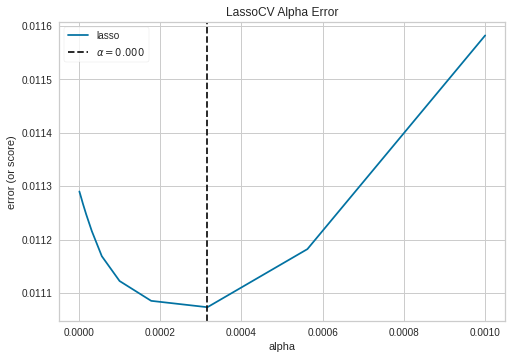

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [68]:
#%%time
# lasso, visualize with yellowbrick
scaler = use_transform()
scaler.fit(X_train[predictors_lasso])
X_tr = scaler.transform(X_train[predictors_lasso])

#alphas = np.logspace(-5, 4, 19)
alphas = np.logspace(-6, -3, 13)
visualizer = AlphaSelection(LassoCV(alphas=alphas, max_iter=200000, cv=kfolds))
visualizer.fit(X_tr, y_train)

alpha = visualizer.estimator.alpha_
print('alpha', alpha)
y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test[predictors_lasso]))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

visualizer.poof()


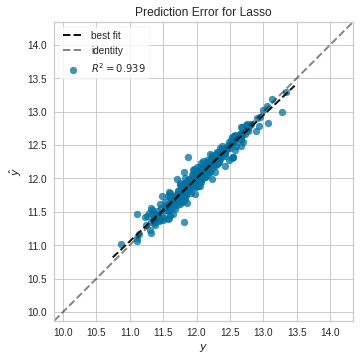

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [69]:
#%%time
visualizer = PredictionError(Lasso(alpha=alpha))
visualizer.fit(X_tr, y_train)
visualizer.score(scaler.transform(X_test[predictors_lasso]), y_test)
visualizer.poof()


In [70]:
%%time
# tune LassoCV search space
# note train error is worse when using lasso regularization but test is better
# regularization reduces overfitting

lasso = make_pipeline(use_transform(),
                      LassoCV(alphas=np.logspace(-6, -4, 9),
                              max_iter=100000,
                              cv=kfolds))

scores = np.sqrt(-cross_val_score(lasso, df[predictors_lasso], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

lasso.fit(X_train[predictors_lasso], y_train)

y_pred_train = lasso.predict(X_train[predictors_lasso])
y_pred_test = lasso.predict(X_test[predictors_lasso])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

print('alpha', lasso._final_estimator.alpha_)


CV Score 0.1029 (STD 0.0112)

Train RMSE 16375.521355733206
Train R-squared 0.9529230561432432
Train MAE 11172.826865184052

Test RMSE 18906.611901440836
Test R-squared 0.9443625636187062
Test MAE 12464.57728992803
alpha 0.0001
CPU times: user 16.9 s, sys: 15.4 s, total: 32.3 s
Wall time: 4.2 s


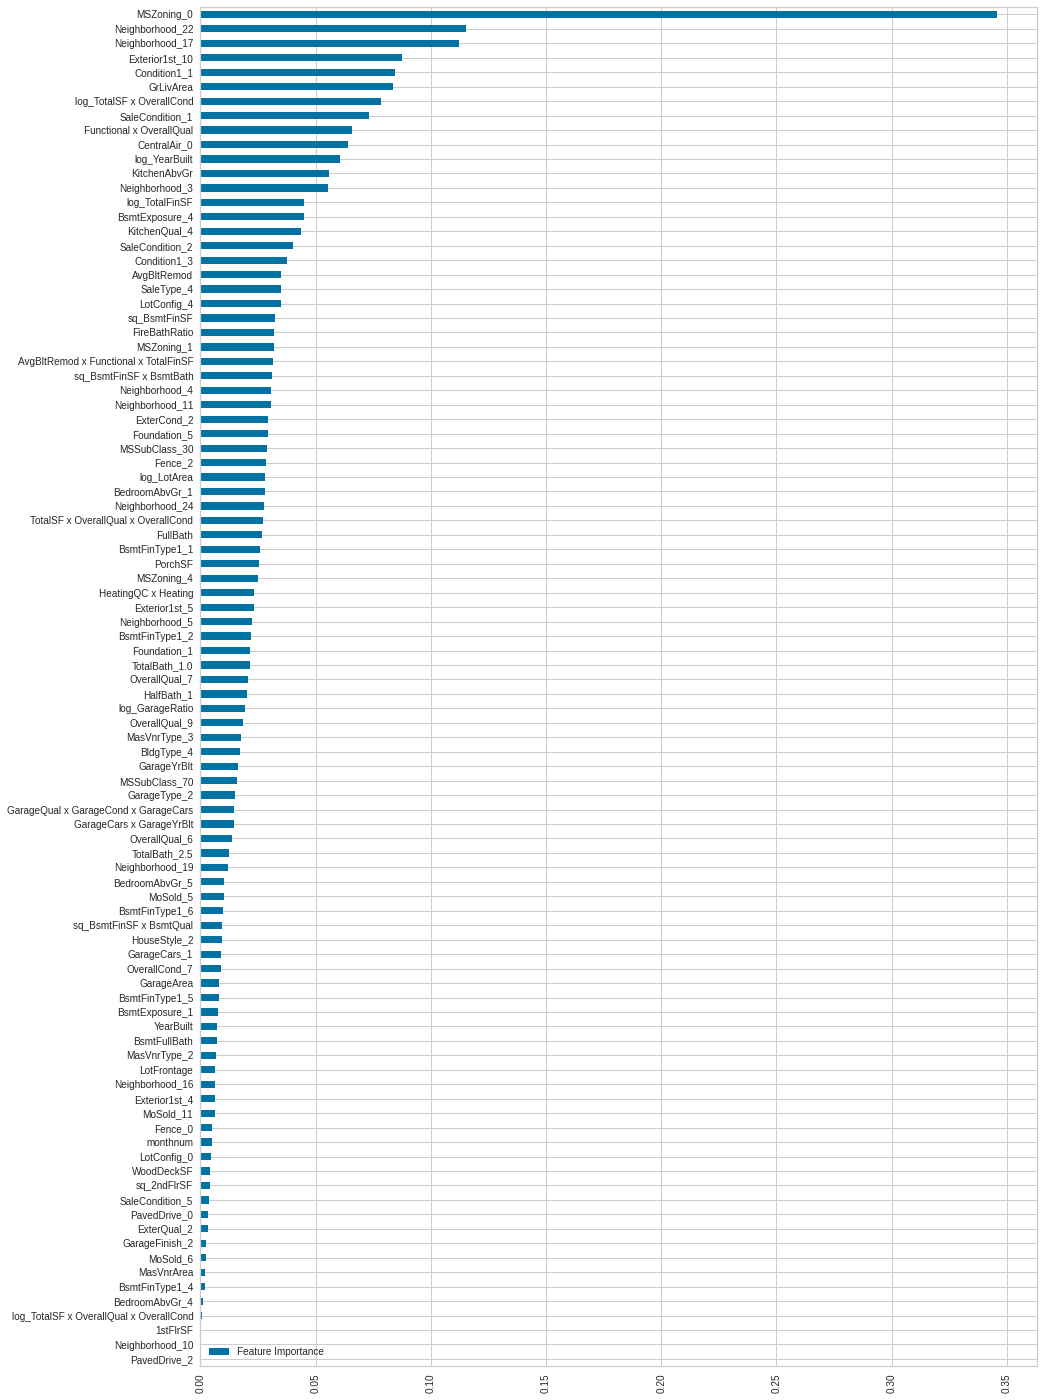

In [71]:
imp_lasso = pd.DataFrame({"Feature Importance" : lasso._final_estimator.coef_}, index=predictors_lasso)
imp_lasso["Feature Importance"]=abs(imp_lasso["Feature Importance"])
imp_lasso[imp_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [72]:
# run this on all features to get lowimportlasso - determine features with 0 coefficients
list(imp_lasso.loc[imp_lasso['Feature Importance']==0].index)

['KitchenAbvGr x KitchenQual',
 'log_AvgBltRemod x TotalFinSF',
 'CentralAir_1',
 'GarageFinish_3',
 'MoSold_1',
 'OverallQual_5']

100
Train RMSE 16472.071536355663
Train R-squared 0.9523662876769876
Train MAE 11209.452861229316

Test RMSE 18817.252383137067
Test R-squared 0.944887246245985
Test MAE 12435.365119021964
alpha 3.981071705534973


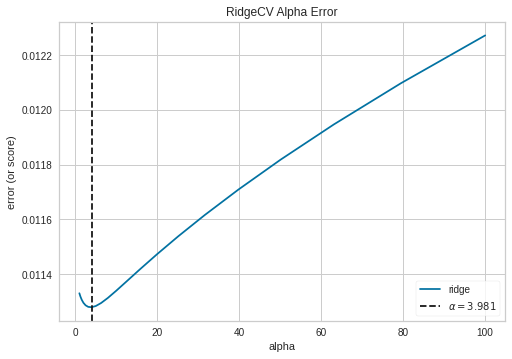

CPU times: user 879 ms, sys: 691 ms, total: 1.57 s
Wall time: 288 ms


<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [73]:
%%time
predictors_ridge = predictors_lasso 
print(len(predictors_ridge))
predictors_dict['ridge'] = predictors_ridge
    
# visualize ridge with yellowbrick
scaler = use_transform()
scaler.fit(X_train[predictors_ridge])
X_tr = scaler.transform(X_train[predictors_ridge])

#alphas = np.logspace(-2, 3, 11)
alphas = np.logspace(0, 2, 21)
visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X_tr, y_train)

y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test[predictors_ridge]))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

alpha = visualizer.estimator.alpha_
print('alpha', alpha)
visualizer.poof()

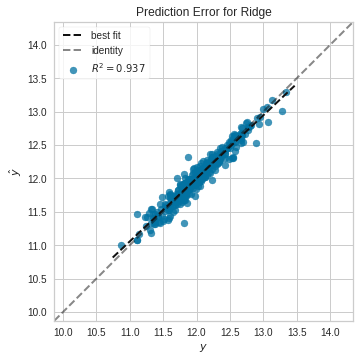

CPU times: user 527 ms, sys: 583 ms, total: 1.11 s
Wall time: 267 ms


<AxesSubplot:title={'center':'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [74]:
%%time
visualizer = PredictionError(Ridge(alpha=alpha))
visualizer.fit(X_train[predictors_ridge], y_train)
visualizer.score(X_test[predictors_ridge], y_test)
visualizer.poof()

In [75]:
%%time
# tune RidgeCV search space
alphas = np.logspace(0, 2, 21)

ridge = make_pipeline(use_transform(),
                      RidgeCV(cv=kfolds, alphas=alphas))

scores = np.sqrt(-cross_val_score(ridge, df[predictors_ridge], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

ridge.fit(X_train[predictors_ridge], y_train)

y_pred_train = ridge.predict(X_train[predictors_ridge])
y_pred_test = ridge.predict(X_test[predictors_ridge])
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('alpha', ridge._final_estimator.alpha_)


CV Score 0.1034 (STD 0.0121)

Train RMSE 16437.02712466341
Train R-squared 0.9525687539793419
Train MAE 11197.425748789652

Test RMSE 18863.813690183666
Test R-squared 0.9446141674142414
Test MAE 12457.131787291428
alpha 3.1622776601683795
CPU times: user 56.5 s, sys: 1min 4s, total: 2min
Wall time: 15.6 s


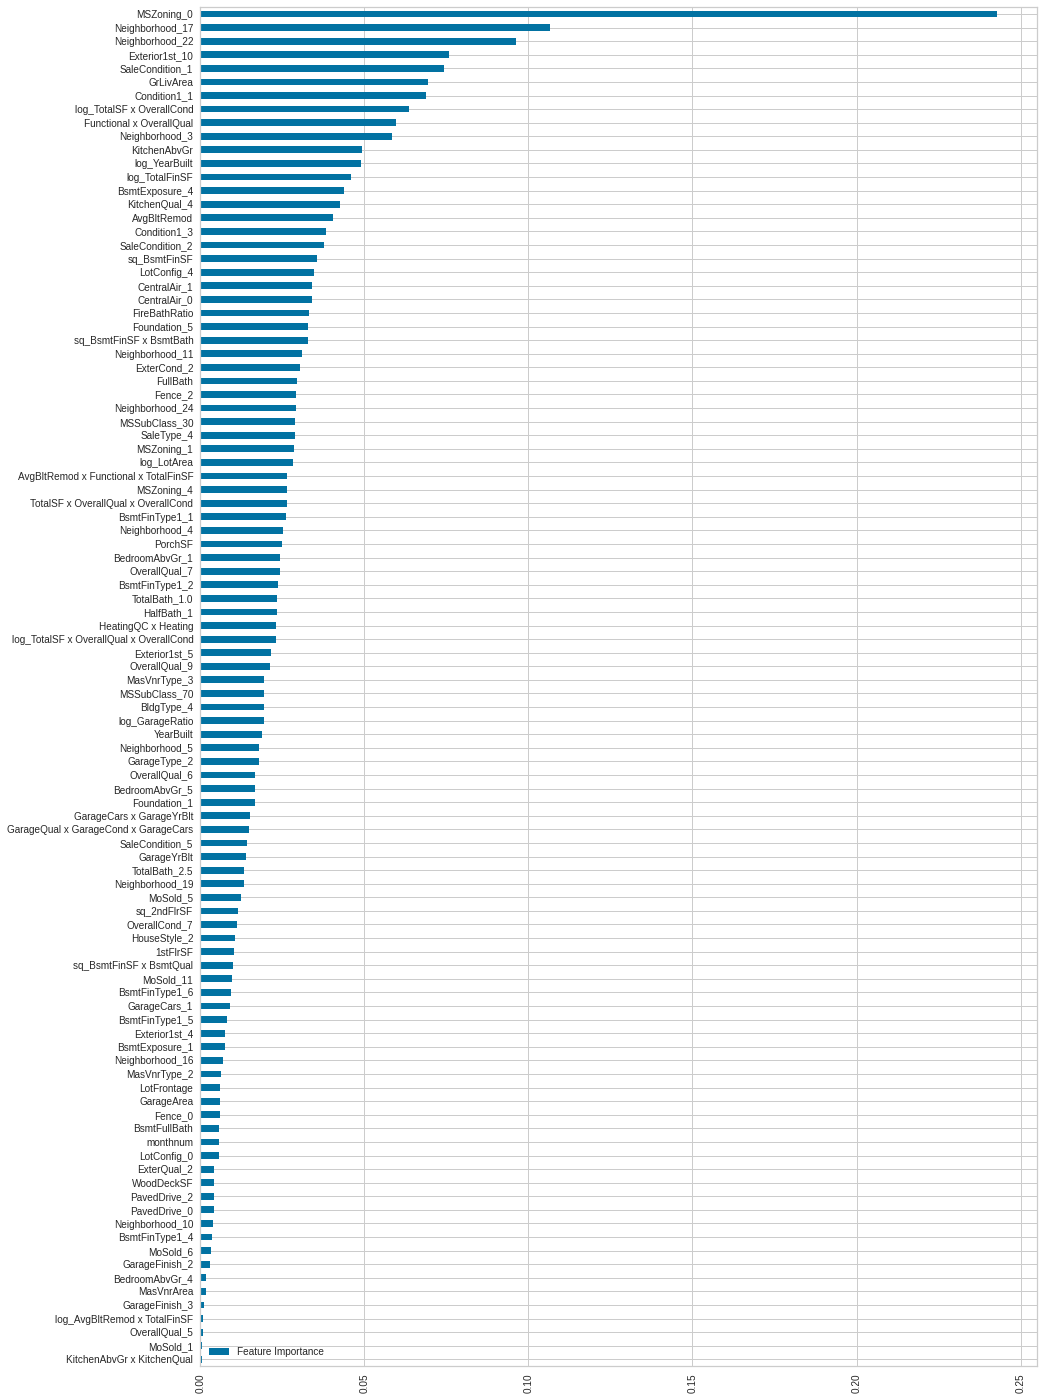

In [76]:
imp_ridge = pd.DataFrame({"Feature Importance" : ridge._final_estimator.coef_}, index=predictors_ridge)
imp_ridge["Feature Importance"]=abs(imp_ridge["Feature Importance"])
imp_ridge[imp_ridge["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [77]:
list(imp_ridge.loc[imp_ridge['Feature Importance']< 0.001].index)

['KitchenAbvGr x KitchenQual',
 'log_AvgBltRemod x TotalFinSF',
 'GarageFinish_3',
 'MoSold_1',
 'OverallQual_5']

In [78]:
%%time
# Tune ElasticNetCV search space for alphas and l1_ratio
print("ElasticNetCV")

predictors_elastic = predictors_lasso
predictors_elastic = [p for p in predictors_elastic if p not in []]
print(len(predictors_elastic))
predictors_dict['elasticnet'] = predictors_elastic

elasticnet = make_pipeline(use_transform(),
                           ElasticNetCV(max_iter=100000, 
                                        #l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                        l1_ratio=np.linspace(0.6, 0.8, 21),
                                        alphas=np.logspace(-4, -2, 21),
                                        cv=kfolds))

scores = np.sqrt(-cross_val_score(elasticnet, df[predictors_elastic], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))

print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

elasticnet.fit(X_train[predictors_elastic], y_train)

y_pred_train = elasticnet.predict(X_train[predictors_elastic])
y_pred_test = elasticnet.predict(X_test[predictors_elastic])
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('l1_ratio', elasticnet._final_estimator.l1_ratio_)
print('alpha', elasticnet._final_estimator.alpha_)


ElasticNetCV
100
CV Score 0.1028 (STD 0.0114)

Train RMSE 16543.403824618308
Train R-squared 0.9519528389103824
Train MAE 11189.009092464166

Test RMSE 18989.55835713337
Test R-squared 0.9438733113502392
Test MAE 12428.547352697944
l1_ratio 0.72
alpha 0.00039810717055349735
CPU times: user 3min 51s, sys: 3min 10s, total: 7min 1s
Wall time: 54.7 s


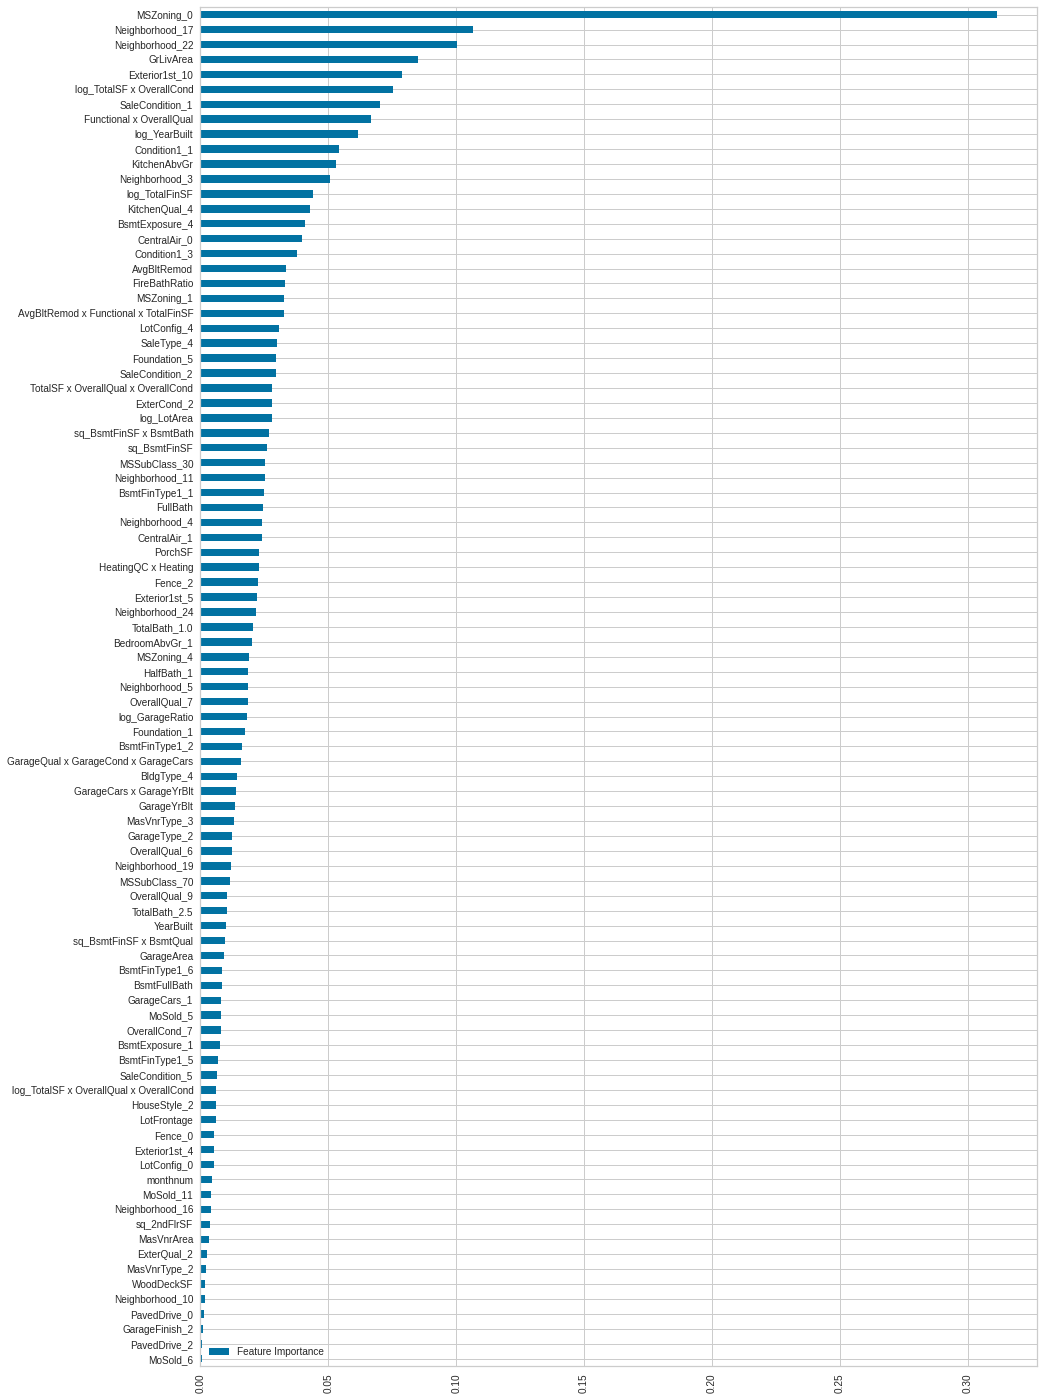

In [79]:
imp_elastic = pd.DataFrame({"Feature Importance" : elasticnet._final_estimator.coef_}, index=predictors_elastic)
imp_elastic["Feature Importance"]=abs(imp_elastic["Feature Importance"])
imp_elastic[imp_elastic["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)

plt.show()

In [80]:
sorted(list(imp_elastic.loc[imp_elastic['Feature Importance']< 0.001].index))

['1stFlrSF',
 'BedroomAbvGr_4',
 'BedroomAbvGr_5',
 'BsmtFinType1_4',
 'GarageFinish_3',
 'KitchenAbvGr x KitchenQual',
 'MoSold_1',
 'MoSold_6',
 'OverallQual_5',
 'PavedDrive_2',
 'log_AvgBltRemod x TotalFinSF']

In [94]:
%%time
# tune KernelRidge
print("KernelRidge")

predictors_kr = predictors_lasso
predictors_kr = [p for p in predictors_kr if p not in []]
predictors_dict['kr'] = predictors_kr

kralphas = np.logspace(-5,0,11)
coef0s = np.linspace(1,10, 19)
krdegrees = [1,2,3]
 
gs = make_pipeline(use_transform(),
                   GridSearchCV(KernelRidge(kernel='poly'),
                                param_grid={'alpha': kralphas,
                                            'degree': krdegrees,
                                            'coef0': coef0s,
                                           },
                                scoring='neg_mean_squared_error',
                                refit=True,
                                cv=kfolds,
                                n_jobs=-1,
                                verbose=1
                               ))

# do cv using kfolds on full dataset
print("\nCV on full dataset")
gs.fit(df[predictors_kr], df[response])
print('best params', gs._final_estimator.best_params_)
print('best score', -gs._final_estimator.best_score_)

# refit and evaluate
kralpha=gs._final_estimator.best_params_['alpha']
krdegree=gs._final_estimator.best_params_['degree']
coef0=gs._final_estimator.best_params_['coef0']
kr = make_pipeline(use_transform(),
                   KernelRidge(alpha=kralpha, kernel='poly', degree=krdegree, coef0=coef0)
                  )
print(kr)
scores = np.sqrt(-cross_val_score(kr, df[predictors_kr], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

kr.fit(X_train[predictors_kr], y_train)

y_pred_train = kr.predict(X_train[predictors_kr])
y_pred_test = kr.predict(X_test[predictors_kr])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

KernelRidge

CV on full dataset
Fitting 10 folds for each of 627 candidates, totalling 6270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6255 out of 6270 | elapsed:  1.7min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 6270 out of 6270 | elapsed:  1.7min finished


best params {'alpha': 0.31622776601683794, 'coef0': 6.0, 'degree': 2}
best score 0.010445335168182728
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kernelridge',
                 KernelRidge(alpha=0.31622776601683794, coef0=6.0, degree=2,
                             kernel='poly'))])
CV Score 0.1015 (STD 0.0121)

Train RMSE 14276.628957580535
Train R-squared 0.9642176107965925
Train MAE 9721.094348398345

Test RMSE 18365.554563641475
Test R-squared 0.947501392356289
Test MAE 12184.535115040693
CPU times: user 8.96 s, sys: 4.36 s, total: 13.3 s
Wall time: 1min 42s


In [99]:
%%time
# tune SVR
print("SVR")

predictors_svr = predictors_lasso
predictors_svr = [p for p in predictors_svr if p not in []]
predictors_dict['svr'] = predictors_svr

svrdegrees = [3]
svrgammas = np.logspace(-4,-1,7)
Cs = np.logspace(1,2,5)
epsilons = np.logspace(-3,-1, 5)
coef0s = np.linspace(0,10, 6)


gs = make_pipeline(use_transform(),
                   GridSearchCV(SVR(kernel='rbf', 
                                    shrinking=True, 
                                    cache_size=200, 
                                    verbose=False, 
                                    max_iter=-1),
                                param_grid={'degree': svrdegrees,
                                            'gamma': svrgammas,
                                            'C': Cs,
                                            'epsilon': epsilons,
                                            'coef0': coef0s,
                                           },
                                scoring='neg_mean_squared_error',
                                refit=True,
                                cv=kfolds,
                                n_jobs=-1,
                                verbose=1
                               ))
                                
print(gs)

# do cv using kfolds on full dataset
print("\nCV on full dataset")
gs.fit(df[predictors_svr], df[response])
print('best params', gs._final_estimator.best_params_)
print('best score', -gs._final_estimator.best_score_)


SVR
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                              estimator=SVR(), n_jobs=-1,
                              param_grid={'C': array([ 10.        ,  17.7827941 ,  31.6227766 ,  56.23413252,
       100.        ]),
                                          'coef0': array([ 0.,  2.,  4.,  6.,  8., 10.]),
                                          'degree': [3],
                                          'epsilon': array([0.001     , 0.00316228, 0.01      , 0.03162278, 0.1       ]),
                                          'gamma': array([0.0001    , 0.00031623, 0.001     , 0.00316228, 0.01      ,
       0.03162278, 0.1       ])},
                              scoring='neg_mean_squared_error', verbose=1))])

CV on full dataset
Fitting 10 folds for each of 1050 candidates, totalling 10500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 57.9min
[Parallel(n_jobs=-1)]: Done 10500 out of 10500

best params {'C': 31.622776601683793, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 0.001}
best score 0.010363760240041419
CPU times: user 44.4 s, sys: 8.39 s, total: 52.8 s
Wall time: 1h 4min 31s


In [102]:
# refit and evaluate
svrdegree=gs._final_estimator.best_params_['degree']
svrgamma=gs._final_estimator.best_params_['gamma']
svrC=gs._final_estimator.best_params_['C']
svrepsilon=gs._final_estimator.best_params_['epsilon']
svrcoef0=gs._final_estimator.best_params_['coef0']

svr = make_pipeline(use_transform(),
                    SVR(kernel='rbf', 
                         degree=svrdegree,
                         gamma=svrgamma,
                         C=svrC,
                         epsilon=svrepsilon,
                         coef0=svrcoef0,
                         shrinking=True, 
                         cache_size=200, 
                         verbose=False, 
                         max_iter=-1)
                   )
print(svr)
scores = np.sqrt(-cross_val_score(svr, df[predictors_svr], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

svr.fit(X_train[predictors_svr], y_train)

y_pred_train = svr.predict(X_train[predictors_svr])
y_pred_test = svr.predict(X_test[predictors_svr])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('svr', SVR(C=31.622776601683793, epsilon=0.01, gamma=0.001))])
CV Score 0.1011 (STD 0.0127)

Train RMSE 13958.286386270613
Train R-squared 0.9657955824591944
Train MAE 8194.792311317182

Test RMSE 18388.528133635704
Test R-squared 0.947369968632672
Test MAE 11848.844205784297


In [108]:
%%time
# tune Gradient Boost
print("Gradient Boost")

predictors_gb=[p for p in predictors_lasso if p not in ['BsmtExposure_3',
                                                        'BsmtFinType2_3',
                                                        'Exterior1st_4',
                                                        'Exterior1st_5',
                                                        'Fence_2',
                                                        'LandSlope_1',
                                                        'MSZoning_0',
                                                        'MoSold_11',
                                                        'MoSold_5',
                                                        'MoSold_8',
                                                        'OverallQual_6',
                                                        'PavedDrive_2',
                                                        'SaleType_4',
                                                        'TotalBath_2.5',
                                                        'log_LowQualFinSF',
                                                       ]]
print(len(predictors_gb))
predictors_dict['gb'] = predictors_gb

gbestimatorss = [int(e) for e in np.logspace(3,4,3)]
gbestimatorss = [10000]
gbdepths = [2]
gblearnrates = np.logspace(-3,-1,5)
gblearnrates = [0.01]
gbsubsamples = [0.8]
gbmin_samples_leaf = [16]
gs = make_pipeline(use_transform(),
                   GridSearchCV(GradientBoostingRegressor(min_samples_leaf=16, 
                                                          loss='huber', 
                                                          max_features='sqrt',
                                                          random_state=RANDOM_STATE),
                                param_grid={'n_estimators': gbestimatorss,
                                            'max_depth': gbdepths,
                                            'subsample': gbsubsamples,
                                            'learning_rate': gblearnrates,
                                            'min_samples_leaf': gbmin_samples_leaf,
                                           },
                                scoring='neg_mean_squared_error',
                                refit=True,
                                cv=kfolds,
                                n_jobs=-1,
                                verbose=1
                               ))
                                
print(gs)

# do cv using kfolds on full dataset
print("\nCV on full dataset")
gs.fit(df[predictors_gb], df[response])
print('best params', gs._final_estimator.best_params_)
print('best score', -gs._final_estimator.best_score_)
                                                                                                         

Gradient Boost
90
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                              estimator=GradientBoostingRegressor(loss='huber',
                                                                  max_features='sqrt',
                                                                  min_samples_leaf=16,
                                                                  random_state=42),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.01],
                                          'max_depth': [2],
                                          'min_samples_leaf': [2, 4, 8, 16, 32],
                                          'n_estimators': [10000],
                                          'subsample': [0.8]},
                              scoring='neg_mean_squared_error', verbose=1))])

CV on full dataset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.4min finished


best params {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 16, 'n_estimators': 10000, 'subsample': 0.8}
best score 0.011616733424834321
CPU times: user 23.8 s, sys: 0 ns, total: 23.8 s
Wall time: 8min 49s


In [112]:
# refit and evaluate
gb_n_estimators = gs._final_estimator.best_params_['n_estimators']
gb_max_depth = gs._final_estimator.best_params_['max_depth']
gb_subsample = gs._final_estimator.best_params_['subsample']
gb_learning_rate = gs._final_estimator.best_params_['learning_rate']
gb_min_samples_leaf = gs._final_estimator.best_params_['min_samples_leaf']
# technically no need to scale for gb
gb = GradientBoostingRegressor(n_estimators=gb_n_estimators,
                                             max_depth=gb_max_depth,
                                             subsample=gb_subsample,
                                             learning_rate=gb_learning_rate,
                                             min_samples_leaf=gb_min_samples_leaf, 
                                             loss='huber', 
                                             max_features='sqrt',
                                             random_state=RANDOM_STATE)
                  
print(gb)
scores = np.sqrt(-cross_val_score(gb, df[predictors_gb], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

gb.fit(X_train[predictors_gb], y_train)

y_pred_train = gb.predict(X_train[predictors_gb])
y_pred_test = gb.predict(X_test[predictors_gb])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=2,
                          max_features='sqrt', min_samples_leaf=16,
                          n_estimators=10000, random_state=42, subsample=0.8)
CV Score 0.1070 (STD 0.0137)

Train RMSE 11716.652160345682
Train R-squared 0.9758995548717659
Train MAE 6864.825861742128

Test RMSE 21570.303677345943
Test R-squared 0.9275810522076466
Test MAE 13331.310421379365


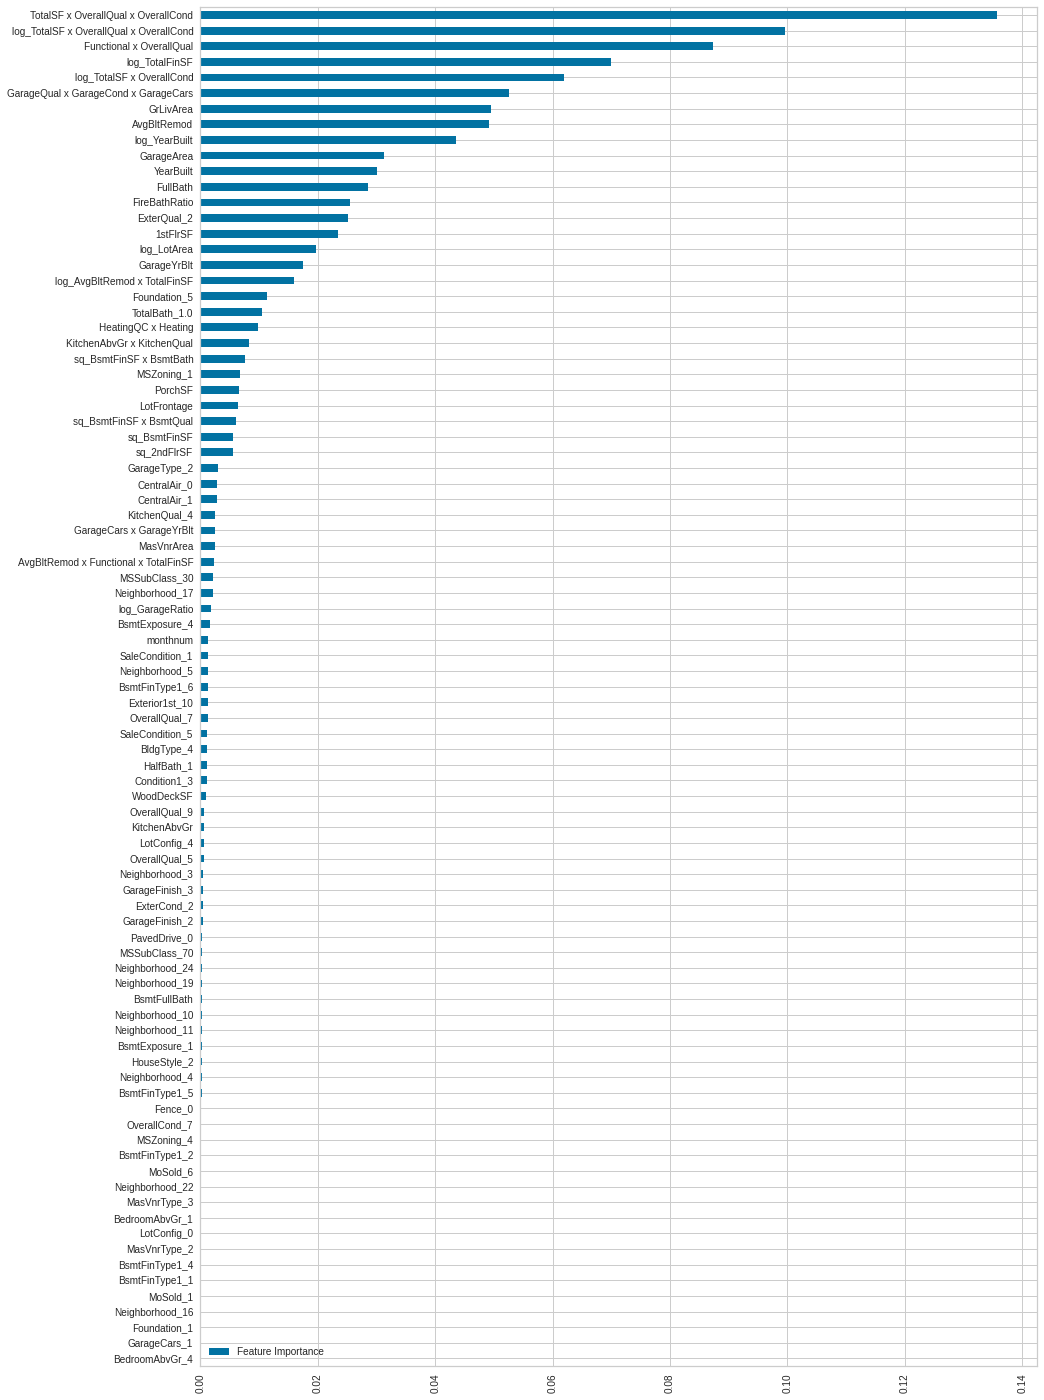

In [113]:
imp_gb = pd.DataFrame({"Feature Importance" : gb.feature_importances_}, index=predictors_gb)
imp_gb["Feature Importance"]=abs(imp_gb["Feature Importance"])
imp_gb[imp_gb["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()


In [114]:
sorted(list(imp_gb.loc[imp_gb['Feature Importance']<=0.0001].index))


['BedroomAbvGr_4',
 'BedroomAbvGr_5',
 'BsmtFinType1_1',
 'BsmtFinType1_4',
 'Condition1_1',
 'Foundation_1',
 'GarageCars_1',
 'MoSold_1',
 'Neighborhood_16',
 'SaleCondition_2']

In [115]:
# %%time
# tune XGBoost
print("XGBoost")
# XGboost - advanced decision tree model
# tune hyperparameters sequentially or in pairs
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
# https://xgboost.readthedocs.io/en/latest/parameter.html
predictors_xgb = predictors_lasso
predictors_dict['xgb'] = predictors_xgb
print(len(predictors_xgb))
#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
#n_estimators_xgb = 5623
n_estimators_xgb = 50000

#max_depth: max depth per base tree
max_depths = range(1,13)
max_depth = 1 #3

min_child_weights=np.linspace(0.0, 1.0, 6)
min_child_weight=0.0

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
# subsample = 0.55
subsample = 0.45 # 0.7

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15 # 0.25 

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-06  # 0.0001 # 

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.1, 0.05, 0.01, 0.005, 0.001]
learning_rate_xgb = 0.05  # 0.01


# n_estimators_xgb= 1336
# max_depth= 2
# subsample= 0.65
# colsample_bytree= 0.35
# reg_alpha= 1.63939e-05
# gamma= 0
# learning_rate_xgb= 0.05

eval_set=[(X_test[predictors_xgb], y_test.values.reshape(-1)),]
dtrain = xgboost.DMatrix(df[predictors_xgb], label=df[response])

for i in [1]:
        
        params = {
            'eval_metric': 'mae',
            'max_depth': max_depth,
            'min_child_weight': min_child_weight,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'reg_alpha': reg_alpha,
            'gamma': gamma,
            'learning_rate': learning_rate_xgb,
        }

        cv_results = xgboost.cv(
            params,
            dtrain,
            num_boost_round=50000,
            seed=RANDOM_STATE,
            nfold=5,
            metrics={'mae'},
            early_stopping_rounds=100
        )
        
        print(params)
        display(cv_results[['test-mae-mean', 'test-mae-std']].sort_values('test-mae-mean').iloc[0])


XGBoost
100
{'eval_metric': 'mae', 'max_depth': 1, 'min_child_weight': 0.0, 'subsample': 0.45, 'colsample_bytree': 0.15, 'reg_alpha': 1e-06, 'gamma': 0, 'learning_rate': 0.05}


test-mae-mean    0.078373
test-mae-std     0.003434
Name: 1013, dtype: float64

In [116]:
# repeat on train-test split 
xgb = XGBRegressor(
    objective='reg:squarederror',
    max_depth=max_depth,
    n_estimators=50000,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    learning_rate=learning_rate_xgb,
    min_child_weight=min_child_weight,
    reg_alpha=reg_alpha,
    n_jobs=-1)

display(xgb)


XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.15, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=1,
             min_child_weight=0.0, missing=nan, monotone_constraints=None,
             n_estimators=50000, n_jobs=-1, num_parallel_tree=None,
             random_state=None, reg_alpha=1e-06, reg_lambda=None,
             scale_pos_weight=None, subsample=0.45, tree_method=None,
             validate_parameters=None, verbosity=None)

In [117]:
# determining rounds
xgb.fit(X_train[predictors_xgb], y_train.values.reshape(-1),
        eval_set=eval_set,
        eval_metric='rmse',
        early_stopping_rounds=100,
        verbose=True) #gives output log as below

scores = np.sqrt(-cross_val_score(xgb, df[predictors_xgb], df[response],
                              scoring="neg_mean_squared_error",
                              cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print(xgb.best_ntree_limit)


[0]	validation_0-rmse:10.95286
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:10.40630
[2]	validation_0-rmse:9.88894
[3]	validation_0-rmse:9.39454
[4]	validation_0-rmse:8.92508
[5]	validation_0-rmse:8.47992
[6]	validation_0-rmse:8.05790
[7]	validation_0-rmse:7.65696
[8]	validation_0-rmse:7.27510
[9]	validation_0-rmse:6.91184
[10]	validation_0-rmse:6.56855
[11]	validation_0-rmse:6.24216
[12]	validation_0-rmse:5.93120
[13]	validation_0-rmse:5.63649
[14]	validation_0-rmse:5.35625
[15]	validation_0-rmse:5.08959
[16]	validation_0-rmse:4.83642
[17]	validation_0-rmse:4.59620
[18]	validation_0-rmse:4.36706
[19]	validation_0-rmse:4.14946
[20]	validation_0-rmse:3.94356
[21]	validation_0-rmse:3.74801
[22]	validation_0-rmse:3.56214
[23]	validation_0-rmse:3.38517
[24]	validation_0-rmse:3.21702
[25]	validation_0-rmse:3.05672
[26]	validation_0-rmse:2.90456
[27]	validation_0-rmse:2.76111
[28]	validation_0-rmse:2.62460
[29]	validation_0-rmse:2.49479
[30]	validat

[258]	validation_0-rmse:0.12782
[259]	validation_0-rmse:0.12784
[260]	validation_0-rmse:0.12774
[261]	validation_0-rmse:0.12770
[262]	validation_0-rmse:0.12744
[263]	validation_0-rmse:0.12736
[264]	validation_0-rmse:0.12728
[265]	validation_0-rmse:0.12718
[266]	validation_0-rmse:0.12721
[267]	validation_0-rmse:0.12716
[268]	validation_0-rmse:0.12713
[269]	validation_0-rmse:0.12696
[270]	validation_0-rmse:0.12695
[271]	validation_0-rmse:0.12696
[272]	validation_0-rmse:0.12685
[273]	validation_0-rmse:0.12674
[274]	validation_0-rmse:0.12676
[275]	validation_0-rmse:0.12662
[276]	validation_0-rmse:0.12659
[277]	validation_0-rmse:0.12654
[278]	validation_0-rmse:0.12645
[279]	validation_0-rmse:0.12642
[280]	validation_0-rmse:0.12644
[281]	validation_0-rmse:0.12629
[282]	validation_0-rmse:0.12623
[283]	validation_0-rmse:0.12611
[284]	validation_0-rmse:0.12607
[285]	validation_0-rmse:0.12584
[286]	validation_0-rmse:0.12575
[287]	validation_0-rmse:0.12570
[288]	validation_0-rmse:0.12571
[289]	va

[515]	validation_0-rmse:0.11916
[516]	validation_0-rmse:0.11928
[517]	validation_0-rmse:0.11926
[518]	validation_0-rmse:0.11922
[519]	validation_0-rmse:0.11922
[520]	validation_0-rmse:0.11914
[521]	validation_0-rmse:0.11908
[522]	validation_0-rmse:0.11907
[523]	validation_0-rmse:0.11903
[524]	validation_0-rmse:0.11899
[525]	validation_0-rmse:0.11888
[526]	validation_0-rmse:0.11886
[527]	validation_0-rmse:0.11884
[528]	validation_0-rmse:0.11880
[529]	validation_0-rmse:0.11863
[530]	validation_0-rmse:0.11865
[531]	validation_0-rmse:0.11869
[532]	validation_0-rmse:0.11869
[533]	validation_0-rmse:0.11871
[534]	validation_0-rmse:0.11878
[535]	validation_0-rmse:0.11873
[536]	validation_0-rmse:0.11869
[537]	validation_0-rmse:0.11858
[538]	validation_0-rmse:0.11856
[539]	validation_0-rmse:0.11850
[540]	validation_0-rmse:0.11845
[541]	validation_0-rmse:0.11847
[542]	validation_0-rmse:0.11827
[543]	validation_0-rmse:0.11829
[544]	validation_0-rmse:0.11823
[545]	validation_0-rmse:0.11827
[546]	va

[772]	validation_0-rmse:0.11629
[773]	validation_0-rmse:0.11627
[774]	validation_0-rmse:0.11630
[775]	validation_0-rmse:0.11628
[776]	validation_0-rmse:0.11625
[777]	validation_0-rmse:0.11632
[778]	validation_0-rmse:0.11628
[779]	validation_0-rmse:0.11633
[780]	validation_0-rmse:0.11632
[781]	validation_0-rmse:0.11635
[782]	validation_0-rmse:0.11633
[783]	validation_0-rmse:0.11637
[784]	validation_0-rmse:0.11638
[785]	validation_0-rmse:0.11633
[786]	validation_0-rmse:0.11630
[787]	validation_0-rmse:0.11630
[788]	validation_0-rmse:0.11628
[789]	validation_0-rmse:0.11628
[790]	validation_0-rmse:0.11626
[791]	validation_0-rmse:0.11630
[792]	validation_0-rmse:0.11633
[793]	validation_0-rmse:0.11628
[794]	validation_0-rmse:0.11632
[795]	validation_0-rmse:0.11632
[796]	validation_0-rmse:0.11629
[797]	validation_0-rmse:0.11627
[798]	validation_0-rmse:0.11622
[799]	validation_0-rmse:0.11616
[800]	validation_0-rmse:0.11623
[801]	validation_0-rmse:0.11622
[802]	validation_0-rmse:0.11622
[803]	va

[1028]	validation_0-rmse:0.11494
[1029]	validation_0-rmse:0.11495
[1030]	validation_0-rmse:0.11490
[1031]	validation_0-rmse:0.11486
[1032]	validation_0-rmse:0.11484
[1033]	validation_0-rmse:0.11484
[1034]	validation_0-rmse:0.11483
[1035]	validation_0-rmse:0.11487
[1036]	validation_0-rmse:0.11487
[1037]	validation_0-rmse:0.11489
[1038]	validation_0-rmse:0.11487
[1039]	validation_0-rmse:0.11485
[1040]	validation_0-rmse:0.11485
[1041]	validation_0-rmse:0.11482
[1042]	validation_0-rmse:0.11483
[1043]	validation_0-rmse:0.11477
[1044]	validation_0-rmse:0.11479
[1045]	validation_0-rmse:0.11477
[1046]	validation_0-rmse:0.11474
[1047]	validation_0-rmse:0.11476
[1048]	validation_0-rmse:0.11481
[1049]	validation_0-rmse:0.11485
[1050]	validation_0-rmse:0.11476
[1051]	validation_0-rmse:0.11476
[1052]	validation_0-rmse:0.11477
[1053]	validation_0-rmse:0.11476
[1054]	validation_0-rmse:0.11473
[1055]	validation_0-rmse:0.11472
[1056]	validation_0-rmse:0.11468
[1057]	validation_0-rmse:0.11466
[1058]	val

[1277]	validation_0-rmse:0.11296
[1278]	validation_0-rmse:0.11302
[1279]	validation_0-rmse:0.11306
[1280]	validation_0-rmse:0.11312
[1281]	validation_0-rmse:0.11310
[1282]	validation_0-rmse:0.11311
[1283]	validation_0-rmse:0.11312
[1284]	validation_0-rmse:0.11310
[1285]	validation_0-rmse:0.11311
[1286]	validation_0-rmse:0.11311
[1287]	validation_0-rmse:0.11309
[1288]	validation_0-rmse:0.11297
[1289]	validation_0-rmse:0.11299
[1290]	validation_0-rmse:0.11297
[1291]	validation_0-rmse:0.11295
[1292]	validation_0-rmse:0.11293
[1293]	validation_0-rmse:0.11297
[1294]	validation_0-rmse:0.11300
[1295]	validation_0-rmse:0.11299
[1296]	validation_0-rmse:0.11304
[1297]	validation_0-rmse:0.11302
[1298]	validation_0-rmse:0.11301
[1299]	validation_0-rmse:0.11304
[1300]	validation_0-rmse:0.11301
[1301]	validation_0-rmse:0.11300
[1302]	validation_0-rmse:0.11300
[1303]	validation_0-rmse:0.11306
[1304]	validation_0-rmse:0.11310
[1305]	validation_0-rmse:0.11308
[1306]	validation_0-rmse:0.11307
[1307]	val

[1526]	validation_0-rmse:0.11235
[1527]	validation_0-rmse:0.11235
[1528]	validation_0-rmse:0.11237
[1529]	validation_0-rmse:0.11231
[1530]	validation_0-rmse:0.11230
[1531]	validation_0-rmse:0.11228
[1532]	validation_0-rmse:0.11230
[1533]	validation_0-rmse:0.11226
[1534]	validation_0-rmse:0.11222
[1535]	validation_0-rmse:0.11221
[1536]	validation_0-rmse:0.11221
[1537]	validation_0-rmse:0.11224
[1538]	validation_0-rmse:0.11225
[1539]	validation_0-rmse:0.11219
[1540]	validation_0-rmse:0.11221
[1541]	validation_0-rmse:0.11213
[1542]	validation_0-rmse:0.11212
[1543]	validation_0-rmse:0.11214
[1544]	validation_0-rmse:0.11214
[1545]	validation_0-rmse:0.11211
[1546]	validation_0-rmse:0.11209
[1547]	validation_0-rmse:0.11208
[1548]	validation_0-rmse:0.11211
[1549]	validation_0-rmse:0.11212
[1550]	validation_0-rmse:0.11216
[1551]	validation_0-rmse:0.11222
[1552]	validation_0-rmse:0.11218
[1553]	validation_0-rmse:0.11218
[1554]	validation_0-rmse:0.11218
[1555]	validation_0-rmse:0.11217
[1556]	val

[1775]	validation_0-rmse:0.11120
[1776]	validation_0-rmse:0.11117
[1777]	validation_0-rmse:0.11110
[1778]	validation_0-rmse:0.11106
[1779]	validation_0-rmse:0.11109
[1780]	validation_0-rmse:0.11110
[1781]	validation_0-rmse:0.11112
[1782]	validation_0-rmse:0.11112
[1783]	validation_0-rmse:0.11113
[1784]	validation_0-rmse:0.11113
[1785]	validation_0-rmse:0.11118
[1786]	validation_0-rmse:0.11120
[1787]	validation_0-rmse:0.11121
[1788]	validation_0-rmse:0.11129
[1789]	validation_0-rmse:0.11140
[1790]	validation_0-rmse:0.11145
[1791]	validation_0-rmse:0.11141
[1792]	validation_0-rmse:0.11145
[1793]	validation_0-rmse:0.11146
[1794]	validation_0-rmse:0.11147
[1795]	validation_0-rmse:0.11146
[1796]	validation_0-rmse:0.11141
[1797]	validation_0-rmse:0.11139
[1798]	validation_0-rmse:0.11142
[1799]	validation_0-rmse:0.11141
[1800]	validation_0-rmse:0.11140
[1801]	validation_0-rmse:0.11145
[1802]	validation_0-rmse:0.11144
[1803]	validation_0-rmse:0.11141
[1804]	validation_0-rmse:0.11138
[1805]	val

In [118]:
num_boost_round = xgb.best_ntree_limit+1
xgb = XGBRegressor(
    objective='reg:squarederror',
    max_depth=max_depth,
    n_estimators=num_boost_round,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    learning_rate=learning_rate_xgb,
    min_child_weight=min_child_weight,
    reg_alpha=reg_alpha,
    n_jobs=-1)

display(xgb)
xgb.fit(X_train[predictors_xgb], y_train.values.reshape(-1),)

y_pred_train = xgb.predict(X_train[predictors_xgb])
y_pred_test = xgb.predict(X_test[predictors_xgb])
evaluate(y_train, y_pred_train, y_test, y_pred_test)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.15, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=1,
             min_child_weight=0.0, missing=nan, monotone_constraints=None,
             n_estimators=1780, n_jobs=-1, num_parallel_tree=None,
             random_state=None, reg_alpha=1e-06, reg_lambda=None,
             scale_pos_weight=None, subsample=0.45, tree_method=None,
             validate_parameters=None, verbosity=None)

Train RMSE 15121.277125357792
Train R-squared 0.9598583762915794
Train MAE 10356.098575578075

Test RMSE 23046.92442095594
Test R-squared 0.9173266288719008
Test MAE 14412.064506782286


In [119]:
# from hyperopt (not shown), better hyperparameters
xgb = XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    n_estimators=1383,
    gamma=0,
    subsample=0.5,
    colsample_bytree=0.1,
    learning_rate=0.05,
    min_child_weight=0,
    reg_alpha=4.3667e-06,
    n_jobs=-1)

display(xgb)
xgb.fit(X_train[predictors_xgb], y_train.values.reshape(-1),)

y_pred_train = xgb.predict(X_train[predictors_xgb])
y_pred_test = xgb.predict(X_test[predictors_xgb])
evaluate(y_train, y_pred_train, y_test, y_pred_test)


XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.1, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=3,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=1383, n_jobs=-1, num_parallel_tree=None,
             random_state=None, reg_alpha=4.3667e-06, reg_lambda=None,
             scale_pos_weight=None, subsample=0.5, tree_method=None,
             validate_parameters=None, verbosity=None)

Train RMSE 6145.844480548054
Train R-squared 0.993368968015763
Train MAE 4473.576039520381

Test RMSE 22603.32001037475
Test R-squared 0.9204785740453743
Test MAE 13759.399843320736


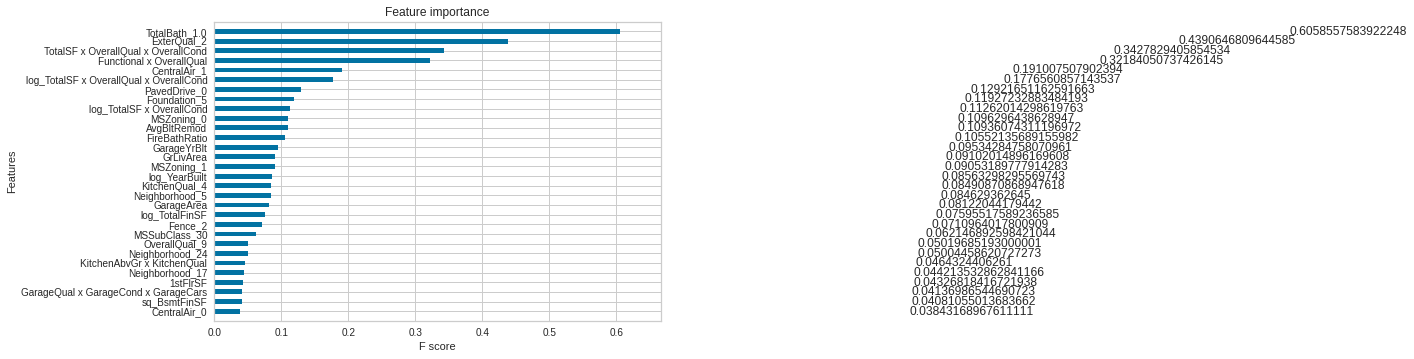

In [120]:
plot_importance(xgb, importance_type='gain', max_num_features=30, height=0.5);

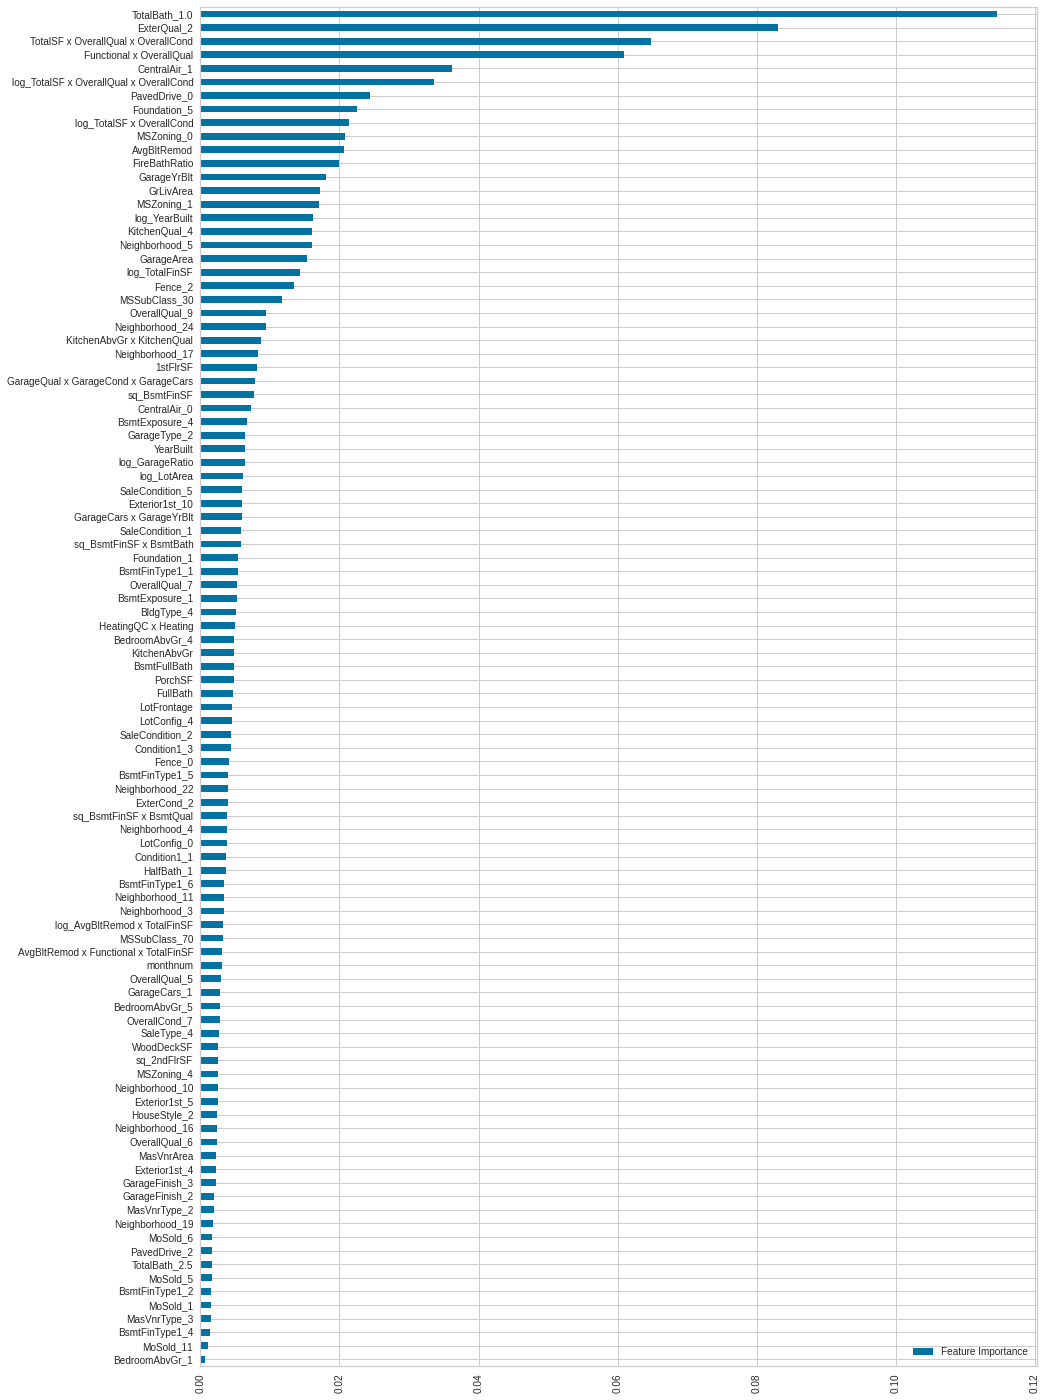

In [121]:
imp_xgb = pd.DataFrame({"Feature Importance" : xgb.feature_importances_}, index=predictors_xgb)
imp_xgb["Feature Importance"]=abs(imp_xgb["Feature Importance"])
imp_xgb[imp_xgb["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()


In [122]:
sorted(list(imp_xgb.loc[imp_xgb['Feature Importance']<0.0001].index))

[]

In [123]:
%%time
# get xgboost interactions, terms that show up in same prediction trees
# alternatives to find interactions:
#   generate many/all interactions (product, ratio, top 30 vs rest) and correlate vs. the residual
#   generate many/all interactions and do lasso to see which ones are retained
interactions = xgb._Booster.predict(xgboost.DMatrix(df[predictors_xgb]), pred_interactions=True)
interaction_matrix = np.mean(np.abs(interactions), axis=0)
# last row, col = bias term
interaction_matrix = interaction_matrix[:-1,:-1]
np.fill_diagonal(interaction_matrix, 0)
interaction_matrix.shape


CPU times: user 5min 2s, sys: 0 ns, total: 5min 2s
Wall time: 5min 2s


(100, 100)

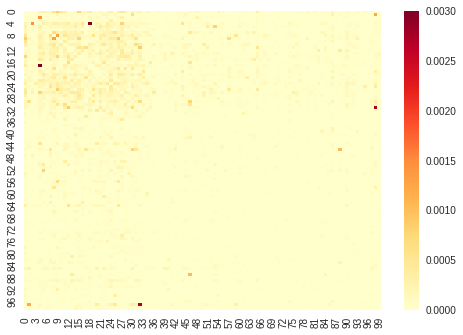

In [124]:
# chart
sns.heatmap(np.abs(interaction_matrix), cmap="YlOrRd", linewidths=0, annot=False, annot_kws={'size': 9}, fmt='.4f');


In [125]:
# print high interaction pairs
# last row, col = bias term
# could also sort, not print out symmetrical pairs
nrows, ncols = interaction_matrix.shape
z = interaction_matrix.copy()[:nrows, :ncols]
z = z.reshape((nrows * ncols))
z.sort()
threshold = z[-100]
print(threshold)
threshold = .0002
interaction_list = []

for i in range(interaction_matrix.shape[0]-1):
    for j in range(interaction_matrix.shape[1]-1):
        # no dupes
        if j > i:
            continue
        if interaction_matrix[i,j] > threshold:
            interaction_list.append((predictors_xgb[i], predictors_xgb[j], interaction_matrix[i,j]))

for tup in sorted(interaction_list, key=lambda x: -x[2]):
    print(tup)
        

0.0004054124
('GarageCars x GarageYrBlt', 'GarageYrBlt', 0.0030011875)
('TotalBath_1.0', 'sq_BsmtFinSF x BsmtBath', 0.002732211)
('GarageYrBlt', 'FullBath', 0.0014587537)
('GarageArea', 'GrLivArea', 0.001291801)
('TotalBath_1.0', 'BsmtFullBath', 0.0012159299)
('PavedDrive_0', 'ExterQual_2', 0.0010497043)
('sq_BsmtFinSF x BsmtBath', 'AvgBltRemod', 0.000884016)
('log_TotalSF x OverallQual x OverallCond', 'GarageArea', 0.0008616614)
('GarageArea', 'YearBuilt', 0.00085264764)
('Foundation_5', 'LotFrontage', 0.0008141848)
('log_TotalSF x OverallCond', 'GarageYrBlt', 0.0007995744)
('AvgBltRemod x Functional x TotalFinSF', 'GarageArea', 0.0007835963)
('ExterQual_2', 'sq_BsmtFinSF', 0.00077602203)
('AvgBltRemod x Functional x TotalFinSF', 'YearBuilt', 0.00076723663)
('sq_BsmtFinSF x BsmtBath', 'sq_BsmtFinSF', 0.00069967035)
('GrLivArea', '1stFlrSF', 0.0006273076)
('KitchenAbvGr x KitchenQual', 'AvgBltRemod', 0.00062707544)
('GarageType_2', 'GarageArea', 0.00062161376)
('sq_BsmtFinSF', 'BsmtFul

In [ ]:
%%time
# tune LightGBM
print("LightGBM")

predictors_lgbm = predictors_lasso
predictors_dict['lgbm'] = predictors_lgbm
print(len(predictors_lgbm))

#n_estimators_lgbm: number of base learner trees
n_estimators_lgbms=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_lgbm = 5623

#max_depth: max depth per base tree
num_leavess = range(2,12)
num_leaves = 5

#subsample: row subsampling rate (similar to RF)
bagging_fractions = np.linspace(0.5, 0.8, 11)
bagging_fraction = 0.75

#colsample_bytree: feature subsampling rate (similar to RF)
feature_fractions = np.linspace(0.05, 0.3, 26)
feature_fraction = 0.1

#learning_rate: shrinkage factor applied to each base tree update
learning_rates = np.logspace(-3, 0, 7)
learning_rates = [0.01]
learning_rate_lgbm = 0.01

for i in [1]:
    print(num_leaves,
          n_estimators_lgbm,
          bagging_fraction,
          feature_fraction,
         )
    
    lgbm = LGBMRegressor(objective='regression',
                         num_leaves=num_leaves,
                         learning_rate=learning_rate_lgbm,
                         n_estimators=n_estimators_lgbm,
                         max_bin=200,
                         bagging_fraction=bagging_fraction,
                         feature_fraction=feature_fraction,
                         feature_fraction_seed=7,
                         min_data_in_leaf=2,
                         verbose=-1,
                         # early stopping params, maybe in fit
                         #early_stopping_rounds=early_stopping_rounds,
                         #valid_sets=[xgtrain, xgvalid], valid_names=['train','valid'], evals_result=evals_results
                         #num_boost_round=num_boost_round,
                         )
    
    scores = np.sqrt(-cross_val_score(lgbm, df[predictors_lgbm], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))

    print()

lgbm.fit(X_train[predictors_lgbm], y_train.values.reshape(-1))
y_pred_train = lgbm.predict(X_train[predictors_lgbm])
y_pred_test = lgbm.predict(X_test[predictors_lgbm])
evaluate(y_train, y_pred_train, y_test, y_pred_test)


In [ ]:
imp_lgbm = pd.DataFrame({"Feature Importance" : lgbm.feature_importances_}, index=predictors_lgbm)
imp_lgbm["Feature Importance"]=abs(imp_lgbm["Feature Importance"])
imp_lgbm[imp_lgbm["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [ ]:
sorted(list(imp_lgbm.loc[imp_lgbm['Feature Importance']==0].index))

In [ ]:
%%time
# tune MLPRegressor
print("MLPregressor")

predictors_mlp = predictors_lasso
predictors_mlp = [p for p in predictors_mlp if p not in []]
predictors_dict['mlp'] = predictors_mlp
print(len(predictors_mlp))

activations = ['relu']
activation = 'relu'

solvers = ['lbfgs']
solver = 'lbfgs'

alphas = np.logspace(0, 2, 3)
alphas = [10]
alpha = 10

learning_rates = ['invscaling']
learning_rate = 'invscaling'

nhiddenlayerss = [1]
nstartlayers = [16, 32, 64, 128,]
layerspecs = product(nhiddenlayerss, nstartlayers)
layerspec = [1, 128]

results_dict = {}

paramlist = product(layerspecs, 
                    activations, 
                    solvers, 
                    alphas, 
                    learning_rates)

mlpmodels = []
for i, (layerspec, activation, solver, alpha, learning_rate) in enumerate(paramlist):
#for i in [1]:
    
    nhiddenlayers, nstartlayer = layerspec
    key = (nhiddenlayers, nstartlayer, alpha)
    mlplayers = []
    for j in range(nhiddenlayers):
        mlplayers.append(nstartlayer)
        nstartlayer = nstartlayer // 4

    print(datetime.datetime.now(), "Iteration %d: %s, %s, %s, alpha = %f, learning rate = %s" % (i,
                            str(mlplayers),
                            activation,
                            solver,
                            alpha,
                            learning_rate,
                           ))
    
    mlp = make_pipeline(use_transform(),
                        MLPRegressor(hidden_layer_sizes=mlplayers,
                                     activation=activation,
                                     solver=solver,
                                     alpha=alpha,
                                     learning_rate=learning_rate,
                                     max_iter=10000))
    
    #print(mlp)
    mlpmodels.append(mlp)
    
    try:
        scores = np.sqrt(-cross_val_score(mlp, df[predictors_mlp], df[response],
                                          scoring="neg_mean_squared_error",
                                          cv=kfolds))
        results_dict[key] = np.mean(scores)
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()
    except:
        pass

mlp.fit(X_train[predictors_mlp], y_train.values.reshape(-1))
y_pred_train = mlp.predict(X_train[predictors_mlp])
y_pred_test = mlp.predict(X_test[predictors_mlp])
try:
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
except:
    pass


In [ ]:
mlp_matrix = pd.DataFrame({
    'nlayers' : [k[0] for k in results_dict.keys()],
    'nunits' : [k[1] for k in results_dict.keys()],
    'alpha' : [np.round(k[2],4) for k in results_dict.keys()],
    'score' : [s for s in results_dict.values()],
})

mlp_pivot = mlp_matrix.pivot_table(index='nunits', 
                                   columns='nlayers',
                                   values='score', 
                                   aggfunc='mean')

sns.heatmap(mlp_pivot, cmap="YlGnBu", linewidths=1.5, annot=True, annot_kws={'size': 11}, fmt='.5f')


### 5. Train and evaluate tuned models on full training set

In [ ]:
# drop outliers with big misses before retrain on full training set, so they don't distort test for submission
# a lot of big misses on low values

#true_y	true_pred	error_stackblend	error_log
#968	135000.0	92484.266535	-42515.733465	-0.378233
#966	37900.0	59176.492175	21276.492175	0.445564
#495	34900.0	55705.837686	20805.837686	0.467587
#1320	147000.0	245498.611640	98498.611640	0.512856
#30	40000.0	70046.574544	30046.574544	0.560270
#462	62383.0	111468.357574	49085.357574	0.580441
#631	82500.0	152209.786746	69709.786746	0.612456

outliers = [968,966,495,1320,30,462,631]
df=df.reset_index(drop=True)
print(df.loc[outliers][response])
print(np.expm1(df.loc[outliers][response]))


In [ ]:
print(df.shape)
df.drop(outliers, inplace=True)
# if you don't reset index here, then on assigment of model results some indexes don't line up and you get NAs 
df=df.reset_index(drop=True)
print(df.shape)
df.tail()


In [ ]:
# store results
full_train_df = pd.DataFrame({'log_y': df[response],
                             'true_y': np.expm1(df[response])
                             })

xval_df = pd.DataFrame({'log_y': df[response],
                       'true_y': np.expm1(df[response])
                       })

cvscores = {}


In [ ]:
%%time

models = {
    'lasso'     : lasso,
    'ridge'     : ridge,
    'elasticnet': elasticnet,
    'kr'        : kr,
    'svr'       : svr,
    'xgb'       : xgb, 
    'lgbm'      : lgbm,
    'gb'        : gb,   
}

for i, m in enumerate(mlpmodels):
    mlpname = "mlp%d" % i
    predictors_dict[mlpname] = predictors_dict['mlp']
    models[mlpname] = m

for k, m in models.items():
    print(datetime.datetime.now(), k)
    
    use_predictors = predictors_dict.get(k)
    if use_predictors is None:
        print('fall back on full')
        use_predictors = predictors_full
        
    # xval predictions
    xval_df[k] = cross_val_predict(m, df[use_predictors], df[response], cv=kfolds)

    # cross-val score
    cvscores[k] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[k]))
    print("CV Score %.04f" % (cvscores[k]))

    # full train
    m.fit(df[use_predictors], df[response])
    full_train_df[k] = m.predict(df[use_predictors])
    
    print()

In [ ]:
blends = {
    'boost_blend': ['xgb', 'lgbm'],
    'linear_blend': ['lasso','ridge','elasticnet','kr'],
    'mlp_blend': ['mlp0', 'mlp1', 'mlp2', 'mlp3'],
}

for blend, components in blends.items():
    xval_df[blend] = np.mean(xval_df[components], axis=1)
    full_train_df[blend] = np.mean(full_train_df[components], axis=1)
    cvscores[blend] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[blend]))
    print("%s CV Score %.04f" % (blend, cvscores[blend]))


### 6. Stack and Blend

In [ ]:
#%%time
#concatenate raw predictors, blends, and stack with xgb
# something off about this , CV is worse than individual blends

df_stack_xval = pd.DataFrame(df[predictors_lasso], columns=predictors_lasso)
df_stack_xval = pd.concat((df_stack_xval, xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
df_stack_xval = use_transform().fit_transform(df_stack_xval)

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 1000

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 2

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.4

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for i in [1]:

    stack_xgb = XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
    print(stack_xgb)
    
    scores = np.sqrt(-cross_val_score(stack_xgb, df_stack_xval, xval_df['log_y'],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print(np.mean(scores))
  
    xval_df['stack_xgb'] = cross_val_predict(stack_xgb,
                                             df_stack_xval, 
                                             xval_df['log_y'], 
                                             cv=kfolds)
    cvscores['stack_xgb'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack_xgb']))
    print("%s CV score %.04f" % ('stack_xgb', cvscores['stack_xgb']))
    
    stack_xgb.fit(df_stack_xval, 
                  xval_df['log_y'])
    
    df_stack_full = pd.DataFrame(df[predictors_lasso], columns=predictors_lasso)
    df_stack_full = pd.concat((df_stack_full, full_train_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
    df_stack_full = use_transform().fit_transform(df_stack_full)
    
    full_train_df['stack_xgb'] = stack_xgb.predict(df_stack_xval)
    print("%s full train score %.04f" % ('stack_xgb', np.sqrt(mean_squared_error(full_train_df['log_y'], full_train_df['stack_xgb']))))


In [ ]:
%%time
# this StackingCVRegressor stack is slow but offers improvement over stacking pre-calculated blends
# with use_features_in_secondary we probably need to scale 

#boost_blend =  VotingRegressor(estimators=[('xgb', xgb), ('lgbm', lgbm)])
#boost_blend.fit(df[predictors], df[response])

#linear_blend = VotingRegressor(estimators=[('lasso', lasso), 
#                                           ('ridge', ridge), 
#                                           ('elasticnet', elasticnet), 
#                                           ('kr', kr)])
#linear_blend.fit(df[predictors], df[response])

#mlp_blend =    VotingRegressor(estimators=[('mlp%d' % i, mlpmodels[i]) for i in range(len(mlpmodels))])
#mlp_blend.fit(df[predictors], df[response])

stack = make_pipeline(use_transform(),
                      StackingCVRegressor(regressors=[xgb, lgbm, 
                                                      lasso, ridge, elasticnet, kr,
                                                      svr, gb
                                                     ] + mlpmodels,
                                          meta_regressor=stack_xgb,
                                          cv=kfolds,
                                          use_features_in_secondary=True))

print(datetime.datetime.now(), "stack xval")
xval_df['stack'] = cross_val_predict(stack, df[predictors_lasso].values, df[response].values, cv=kfolds)
print(datetime.datetime.now(), "xval finished")

# compute crossval score
cvscores['stack'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack']))
print(datetime.datetime.now(), "stack crossval score %.6f" % cvscores['stack'])

print(datetime.datetime.now(), "full train")
stack.fit(df[predictors_lasso].values, df[response].values)
full_train_df['stack'] = stack.predict(df[predictors_lasso].values)
print(datetime.datetime.now(), "full train finished")


In [ ]:
%%time
# stack again using a weighted average.
# 1st level stack does xval_predict using base models and features, meta prediction using base features+predictions
# 2nd level fit lasso model to the base models + stack
# get a weighted avg of all models, no intercept, positive coefs
# on further review, fit_intercept=False screws it up, puts all weight on 1st model, seems like a bug 

# since individual regressors are pipelines that do scaling
# and the metaregressor doesn't use features
# shouldn't need to transform

# note - this should do the same,
# will re-run all models instead of using xval_df (slower and less explicit)
# blendcv = StackingCVRegressor(regressors=blendpredictors,
#                               meta_regressor=blendlasso,
#                               cv=kfolds,
#                               use_features_in_secondary=False)
# blendcv.fit(df[predictors].values, df[response].values)

print(datetime.datetime.now())

blendlasso = LassoCV(alphas=np.logspace(-6, -4, 5),
                     max_iter=100000,
                     cv=kfolds,
                     fit_intercept=True,
                     positive=True)
                           
blendpredictors = ['stack', 'stack_xgb', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]
blendlasso.fit(xval_df[blendpredictors],
               xval_df['log_y'])

xval_df['stackblend']=blendlasso.predict(xval_df[blendpredictors])
cvscores['stackblend'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stackblend']))
print("stackblend crossval score %.6f" % cvscores['stackblend'])

full_train_df['stackblend']= blendlasso.predict(full_train_df[blendpredictors])
print("stackblend full train score %.6f" % np.sqrt(mean_squared_error(full_train_df['log_y'], 
                                                                      full_train_df['stackblend'])))
print('coefs', dict(zip(blendpredictors,
                        list(blendlasso.coef_))))
print('coefs adjusted to sum to 1', blendlasso.coef_/np.sum(blendlasso.coef_))
print('intercept', blendlasso.intercept_)
print('sum', np.sum(blendlasso.coef_))
print('alpha', blendlasso.alpha_ )


In [ ]:
xval_df.head()

In [ ]:
xval_corr = xval_df[blendpredictors].corr()
sns.heatmap(xval_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


In [ ]:
full_train_corr = full_train_df[['stack', 'stack_xgb', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]].corr()
sns.heatmap(full_train_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


In [ ]:
## review final CV scores

for col in xval_df.columns:
    if col in ['true_y', 'log_y', 'true_pred', 'error_stackblend']:
        continue
        
    print(col)
    evaluate2(xval_df[col], xval_df['log_y'])
    print('CV:', cvscores.get(col))
    print()


In [ ]:
full_train_df['error_log'] = full_train_df['stackblend'] - full_train_df['log_y']
full_train_df['true_y'] = np.expm1(full_train_df['log_y'])
full_train_df['true_pred'] = np.expm1(full_train_df['stackblend'])
full_train_df['error_stackblend'] = full_train_df['true_pred'] - full_train_df['true_y']
full_train_df.describe()


In [ ]:
# plot save residuals to analyze vs. columns, interactions
residual = full_train_df[['log_y','true_y', 'true_pred', 'stackblend', 'error_stackblend', 'error_log']]
residual.reset_index(inplace=True)
residual['index'] += 1
residual.to_csv('residual_temp.csv', index=False)

sns.distplot(residual['error_log'], kde=False, fit=stats.norm)


In [ ]:
res = stats.probplot(residual['error_log'], plot=plt);

In [ ]:
sns.regplot(x="log_y", y="error_log", data=residual, scatter_kws={"s": 5}).set_title('Error v. Actual');


In [ ]:
sns.regplot(x="stackblend", y="error_log", data=residual, scatter_kws={"s": 5}).set_title('Error v. Predicted');

In [ ]:
sns.lmplot(x="stackblend", y="error_log", data=residual,
           order=4, scatter_kws={"s": 5});

In [ ]:
# maybe worth making a kludgy adjustment 
# there might be a more systematic way of forcing toward a prior distribution
full_train_df['bias_adjustment'] = (full_train_df['stackblend'] - 11.5) * 0.2
full_train_df['bias_adjustment'] = full_train_df['bias_adjustment'].apply(lambda x: x if x < 0 else 0)
full_train_df['bias_adjustment'].hist()
residual['z'] = full_train_df['stackblend'] + full_train_df['bias_adjustment']
residual['ez'] = residual['z'] - residual['log_y']

sns.lmplot(x="z", y="ez", data=residual,
           order=4, scatter_kws={"s": 5});

In [ ]:
full_train_df.sort_values('error_stackblend')[['true_y','true_pred','error_stackblend', 'error_log']]
full_train_df.sort_values('error_log')[['true_y','true_pred','error_stackblend', 'error_log']]


### 7. Run on test set, export CSV for submission

In [ ]:
# raw models

submit_df = pd.DataFrame({'xgb'       : xgb.predict(df_test[predictors_xgb]), 
                          'lgbm'      : lgbm.predict(df_test[predictors_lgbm]),
                          'gb'        : gb.predict(df_test[predictors_gb]),
                          'svr'       : svr.predict(df_test[predictors_svr]),
                          'lasso'     : lasso.predict(df_test[predictors_lasso]),
                          'ridge'     : ridge.predict(df_test[predictors_ridge]),
                          'elasticnet': elasticnet.predict(df_test[predictors_elastic]),
                          'kr'        : kr.predict(df_test[predictors_kr]),
                          'stack'     : stack.predict(df_test[predictors_lasso])
                         })
for i, m in enumerate(mlpmodels):
    submit_df["mlp%d" % i] = m.predict(df_test[predictors_mlp])

#blends

for blend, components in blends.items():
    submit_df[blend] = np.mean(submit_df[components], axis=1)

# fix ids to line up with test
submit_df.reset_index(inplace=True)
submit_df.rename(columns={'index': 'Id'}, inplace=True)
submit_df['Id']+=1461
submit_df.set_index('Id', inplace=True)
                    
# create stack dataset

submit_stack = pd.DataFrame(df_test[predictors_lasso],
                            columns=predictors_lasso)
submit_stack = pd.concat((submit_stack, submit_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
submit_stack = use_transform().fit_transform(submit_stack)
submit_df['stack_xgb'] = stack_xgb.predict(submit_stack)

# blend prediction
submit_df['stackblend']=blendlasso.predict(submit_df[blendpredictors])

# force weights to sum to 1, no intercept
submit_df['stackblend2'] = \
     0.0 * submit_df['stack'] + \
     0.0        * submit_df['stack_xgb'] + \
     0.17401562  * submit_df['boost_blend'] + \
     0.15988875 * submit_df['gb']  + \
     0.0        * submit_df['mlp_blend'] + \
     0.37571465 * submit_df['svr'] + \
     0.29038099 * submit_df['linear_blend']

# alternate rounded weights , floor at 0.05, cap at 0.25
# the stack and a linear model are usually in the top tier, svr and gb are often up there, want to include all
submit_df['stackblend3'] = \
     0.10       * submit_df['stack'] + \
     0.15       * submit_df['boost_blend'] + \
     0.15       * submit_df['gb'] + \
     0.10       * submit_df['mlp_blend'] +\
     0.15       * submit_df['svr'] + \
     0.35       * submit_df['linear_blend'] 

submit_df.head()


In [ ]:
submit_df['bias_adjustment'] = (submit_df['stackblend'] - 11.5) * 0.2
submit_df['bias_adjustment'] = submit_df['bias_adjustment'].apply(lambda x: x if x < 0 else 0)
submit_df['stackblend_adjust'] = submit_df['stackblend'] + submit_df['bias_adjustment']
submit_df['stackblend3_adjust'] = submit_df['stackblend3'] + submit_df['bias_adjustment']
submit_df['bias_adjustment'].hist()

In [ ]:
submit_df =np.expm1(submit_df)
submit_df.describe()


In [ ]:
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['boost_blend']}).to_csv('boost_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['linear_blend']}).to_csv('linear_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['mlp_blend']}).to_csv('mlp_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['svr']}).to_csv('svr.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['gb']}).to_csv('gb.csv', index=False)

pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend']}).to_csv('stackblend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stack']}).to_csv('stack.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stack_xgb']}).to_csv('stack_xgb.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend2']}).to_csv('stackblend2.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3']}).to_csv('stackblend3.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend_adjust']}).to_csv('stackblend_adjust.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3_adjust']}).to_csv('stackblend3_adjust.csv', index=False)

print(datetime.datetime.now())


 ### If you got this far 
 - At time of writing 05/2019 there are 2 Kaggle contests using this data set
     - https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard
     - https://www.kaggle.com/c/home-data-for-ml-course/leaderboard
 - 1st contest is tougher leaderboard, this solution is about .115 log error,  top 250 / 4500, 
 - Maybe top 5% after accounting for blenders, people who posted others' top kernels, peeked at test set solutions LOL
     - looking at people who posted top kernels, some of them blend with other people's results
     - and data is publicly available so it's possible to look up solutions for the test set
 - 2nd contest (InClass) is softer leaderboard, this solution came in about 12500 raw error, rank top 100 / 5000, top 2%
 - Observing that other people blended, I blended output from this with 3 other top kernels:
    - https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force
    - https://www.kaggle.com/couyang/hybrid-svm-benchmark-approach-0-11180-lb-top-2
    - https://www.kaggle.com/zavodrobotov/lasso-model-for-regression-problem
 - Blend achieved #156 and #3 on 2 leaderboards 0.110, 12100
 - Seems pointless to blend but was curious how high I could go
 - Could maybe improve raw model a little further
     - A very careful visual or systematic examination of which predictors should be dummified, transformed
     - Systematic elimination of non-helpful predictors
     - Add additional models, for averaging, stacking
 - Pretty curious how top results were achieved, quite a few in .1106 range, brute force, more clever features, or just better blending top kernels?
 